<a href="https://colab.research.google.com/github/realtommypoole/AAI-511-Team-7-Compo-Identi/blob/main/Project_Report_Team7(1504).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Composer Classification Using Deep Learning
##Using Deep Learning Algorithms to Predict Composers

University of San Diego, Shiley-Marcos School of Engineering

Masters of Applied Artificial Intelligence

Professor Dr. Rod Albuyeh

Team 7 - Atul Prasad & Tommy Poole

Aug 11, 2025

---
## Abstract

Overivew or project and final results

---

##Introduction
Deep learning algorithms are effective in making accurate predictions using a variety of data types. This project utilizes music data, specifically MIDI files from four classical composers, Bach, Beethoven, Chopin, Mozart, in order to train deep learning networks, specifically Long Short Term Memory (LSTM) and Convolutional Neural Network (CNN) architectures, to accurately predict the composer of a given song.


##Dataset Description

The dataset used in this project originates from the MIDI Classic Music collection available on Kaggle (Fedorak, 2018). This dataset contains classical music compositions encoded in the Musical Instrument Digital Interface (MIDI) format. MIDI files are particularly well-suited for computational music analysis because they store symbolic representations of music—such as note pitch, duration, velocity (loudness), and timing—rather than raw audio waveforms.

MIDI files as an audio recording are  “about capturing the sound of the actual performance. MIDI recording or ‘sequencing’ is about capturing the actual notes of the performance” (Roland, n.d.). Extracting key features from these files, similar to the kinds of features a human would use to identify a unique composer, such as “musical complexity in the melodic line, harmonies, chord progressions, polyrhythm, variations in tempo, the use of counterpoint, ostinato, pedal point, the use of certain stylistic cadences, the selection of instruments, and changes in time and key signatures, and overall structure (sonata form, fugue, dance, etc)” is a critical element of data processing (Fedorak, 2018).

In order to handle MIDI files, a python library, “pretty_midi”. Introduced in 2014, is for “creating, manipulating and analyzing MIDI files. It is intended to make the most common operations applied to MIDI data as straightforward and simple as possible” (Raffel, 2014). This library was utilized extensively to manipulate the data and extract critical features used to train both models.

##Methodology

The methodology outline followed seven steps.

1. **Data Collection:** Data was downloaded from Kaggle (Fedorak, 2018).
2. **Data Preprocessing:** Extensive processing was required to extract the files from zipped folders and to convert the musical scores into a format suitable for the deep learning models.
3. **Feature Extraction:** Features such as notes, chords, key, note sequence, and many more were extracted from the MIDI files using the python pretty_midi library.
4. **Model Building:** Each model was developed and tuned to classify the musical scores according to the composer.
5. **Model Training:** Each built model was trained with the procssed features over numerous epochs.
6. **Model Evaluation:** Several evaluation metrics from the SciKit Learn library were leverated to evaluate the performance of each model, including accuracy, precision, and recall metrics.
7. **Model Optimization:** Each model was iteratively optimized, including improved data processing and hyper parameter tunnig to optimize perfomance.

___

Given the complexity of each model, the project included a data processing, feature extraction, model building, training, and evaluation portion.

#**Data Collection**

Data Collection & Preprocessing are slightly blended in this section which includes:

* Download Python libraries
* Define key variables, and universal random seed for reproducability
* File download & processing, including unzipping

In [1]:
#Install Required Python Libraries quietly to reduce printout
!pip install kaggle -q
!pip install pretty_midi -q

In [2]:
#Import Key Libraries

#Standard Libraries
import os
import re
import ast
import random
import shutil
import zipfile
from zipfile import ZipFile
import warnings
from itertools import cycle

#Third-Party Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import mido
import pretty_midi
import pretty_midi as pm
import kagglehub as kagglehub

#Scikit-learn
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc,
    roc_auc_score, average_precision_score, precision_recall_curve,
    RocCurveDisplay, top_k_accuracy_score
)

#TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [3]:
#Set desired file path
IS_GOOGLE_COLAB = False #Determines if running in cloud, or locally, dynamically adjusts storage
COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart'] #Defines specific composers to store and predict
DATASET_ID = "blanderbuss/midi-classic-music" #Kaggle data identifier
MIDI_DATA_DIR = '/content/midi_data' #Specify storage location
DESTINATION_DIR = "/tmp" #Specify storage location
SOURCE_DATA_DIR = DESTINATION_DIR #Specify storage location
SUPPORTED_EXT = ['.mid', '.midi'] #Ensure only .mid and .midi are processed

if IS_GOOGLE_COLAB == False:
    MIDI_DATA_DIR = os.path.join(os.getcwd(), 'midi_data')

In [4]:
#Set universal random seed for codeset for reproducibility
SEED = 42

def set_random_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(SEED)

**NOTE:** The below codeblock is useful in case of user is running the code multiple times. This will get the latest updated data and be in sync with any change in source data over the time.

In [5]:
# ----------------------------------
#Function: Delete a folder and all its contents
# ----------------------------------
def delete_folder_recursive(folder_path):

    if os.path.exists(folder_path):
        try:
            shutil.rmtree(folder_path)
            print(f" Deleted folder and its contents: {folder_path}")
        except Exception as e:
            print(f"[ERROR] Failed to delete {folder_path}: {e}")
    else:
        print(f"[INFO] Folder does not exist: {folder_path}")

#Execute function
delete_folder_recursive("/content/midi_data")

 Deleted folder and its contents: /content/midi_data


## Data Download
This code block downloads the dataset from Kaggle using kagglehub, copies it into the specified local directory (DESTINATION_DIR). Extracts all .zip archives, including nested zips, ensuring the deepest levels of compressed data are accessible, and then organizes MIDI files into composer-specific folders.

In [6]:
# -------------------------------
#Function: Download Dataset via KaggleHub
# -------------------------------
def download_dataset(dataset_id):
    # Print the dataset being downloaded
    print(f"Downloading dataset: {dataset_id}")
    # Use KaggleHub API to download the dataset to a temporary location
    dataset_path = kagglehub.dataset_download(dataset_id)
    # Notify user of the download location
    print(f"Dataset downloaded to temporary path: {dataset_path}")
    return dataset_path

# -------------------------------
#Function: Copy Dataset to Destination
# -------------------------------
def copy_dataset(source_path, destination_path):
    # Create destination folder if it does not exist
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        print(f"Created destination folder: {destination_path}")

    try:
        # Copy entire dataset directory to destination (allowing overwrite)
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
        print(f"Dataset copied from '{source_path}' to '{destination_path}'")
    except Exception as e:
        print(f"[ERROR] Could not copy dataset: {e}")

# ----------------------------------
#Function: Create base output folder and composer folders
# ----------------------------------
def create_composer_folders(base_dir, composers):
    # Ensure base output directory exists
    os.makedirs(base_dir, exist_ok=True)
    # Create subfolder for each composer
    for composer in composers:
        composer_dir = os.path.join(base_dir, composer)
        os.makedirs(composer_dir, exist_ok=True)

# ----------------------------------
#Function: Recursively extract all .zip files in a directory
# ----------------------------------
def extract_all_nested_zips(base_path):
    # Traverse all directories and files within base_path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith('.zip'):
                zip_path = os.path.join(root, file)
                extract_path = os.path.splitext(zip_path)[0]
                # Extract contents of the ZIP file
                try:
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_path)
                        #print(f"Extracted: {zip_path} -> {extract_path}")
                except zipfile.BadZipFile:
                    print(f"[WARNING] Skipped invalid ZIP: {zip_path}")
                    continue
                except Exception as e:
                    print(f"[ERROR] Failed to extract {zip_path}: {e}")
                    continue
                # Recursively extract deeper levels
                extract_all_nested_zips(extract_path)

# ----------------------------------
#Function: Copy .midi files to composer folders
# ----------------------------------
def copy_midi_files_to_composer_folders(source_dir, target_dir, composers):
    # Walk through all files and directories in the source
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            # Process only .mid or .midi files
            if file.lower().endswith('.mid') or file.lower().endswith('.midi'):
                full_path = os.path.join(root, file)
                for composer in composers:
                    if composer.lower() in full_path.lower():
                        destination = os.path.join(target_dir, composer, file)
                        try:
                            shutil.copy2(full_path, destination)
                            #print(f"Copied: {full_path} -> {destination}")
                        except Exception as e:
                            print(f"[ERROR] Failed to copy {full_path}: {e}")
                        break

# ----------------------------------
#Function: Orchestrator function
# ----------------------------------
def organize_midi_data():
    # Create output structure
    create_composer_folders(MIDI_DATA_DIR, COMPOSERS)

    # Extract all ZIPs (even nested)
    extract_all_nested_zips(SOURCE_DATA_DIR)

    # Copy relevant .midi files to target composer folders
    copy_midi_files_to_composer_folders(SOURCE_DATA_DIR, MIDI_DATA_DIR, COMPOSERS)

# ----------------------------------
#Function: Print summary of .mid/.midi files per composer
# ----------------------------------
def print_midi_file_summary(composer_dir, composers):
    summary = {}

    for composer in composers:
        folder_path = os.path.join(composer_dir, composer)
        count = 0

        # Count .mid and .midi files only
        for file in os.listdir(folder_path):
            ext = os.path.splitext(file)[1].lower()
            if ext in SUPPORTED_EXT:
                count += 1

        summary[composer] = count

    print("\n MIDI File Summary per Composer:")
    print("----------------------------------")
    for composer, count in summary.items():
        print(f"{composer}: {count} files")

# -------------------------------
#Function: Full Setup Pipeline
# -------------------------------
def setup_dataset():
    source = download_dataset(DATASET_ID)
    copy_dataset(source, DESTINATION_DIR)
    organize_midi_data()

#Execute functions for data download and organization
setup_dataset()
print_midi_file_summary(MIDI_DATA_DIR, COMPOSERS)

Dataset downloaded to temporary path: /kaggle/input/midi-classic-music
Dataset copied from '/kaggle/input/midi-classic-music' to '/tmp'

 MIDI File Summary per Composer:
----------------------------------
Bach: 1050 files
Beethoven: 220 files
Chopin: 138 files
Mozart: 259 files


# **Data Pre-Processing & Feature Extraction**

While conceptually seperate steps outlined in the methodology above, data pre-processing and feature extraction are blended in this section as the files are processed, and prepared for modeling.

A critical issue this data, and the types of features needed for sequential modeling, is storage management. This section includes code blocks designed to minimize RAM usage so that this code can run in a Google CoLab environment.

In order to minimize MIDI files are

Discovers, labels, and indexes MIDI files for four classes (Bach, Beethoven, Chopin, Mozart):

It recursively scans base_dir for files with extensions in supported_ext.

It assigns each file to the first composer whose name appears in the file path (case‑insensitive).

For supervised learning, we require pairs (𝑥𝑖,𝑦𝑖) where  𝑥𝑖 is a MIDI file path and 𝑦𝑖∈{Bach,Beethoven,Chopin,Mozart}, which is the canonical input to LSTM

In [7]:
# -------------------------------
#Function: Get Composer MIDIs
# -------------------------------
#Finds MIDI file paths for selected composers in the downloaded files and return a dataframe a a dict mapping composers to their files.
def get_composer_midis(base_dir, composers, supported_ext=('.mid', '.midi')):
    matched_paths = []

    for root, dirs, files in os.walk(base_dir):
        for f in files:
            file_path = os.path.join(root, f)
            if file_path.lower().endswith(supported_ext):
                for composer in composers:
                    if composer.lower() in file_path.lower():
                        matched_paths.append({'filepath': file_path, 'composer': composer})
                        break  # Only assign first matching composer

    #Create DataFrame from filepaths
    df = pd.DataFrame(matched_paths)
    pd.set_option('display.max_colwidth', None)

    #Drop any rows where composer is not found (shouldn't happen, but kept for safety)
    df = df.dropna(subset=['composer'])

    #Collect filepaths for each composer
    composer_files = {composer: df[df['composer'] == composer]['filepath'].tolist() for composer in composers}

    #Print stats to validate
    for composer, files in composer_files.items():
        print(f"{composer}: {len(files)} files")

    return df, composer_files

#Execute function defined above
df, composer_files = get_composer_midis(MIDI_DATA_DIR, COMPOSERS)

Bach: 1050 files
Beethoven: 220 files
Chopin: 138 files
Mozart: 259 files


In [8]:
#Review Dataframe to validate format
df.head()

,filepath,composer
0,/content/midi_data/Mozart/K317 Coronation Mass 6mov.mid,Mozart
1,/content/midi_data/Mozart/K309 Piano Sonata n10 2mov.mid,Mozart
2,/content/midi_data/Mozart/K608 Fantasia for Mechanical Organ.mid,Mozart
3,/content/midi_data/Mozart/Symphony n41 K551 2mov ''Jupiter''.mid,Mozart
4,/content/midi_data/Mozart/Piano Sonata n07 K309.mid,Mozart


In [9]:
# -------------------------------
#Function: Balance Dataset
# -------------------------------
def balance_bach_dataset(df, bach_name, seed, bach_frac):
    #Select only Bach rows and randomly sample a fraction of them
    df_bach = df[df['composer'] == bach_name].sample(frac=bach_frac, random_state=seed)

    #Select all non-Bach rows, grouped by composer, and shuffle within each group
    df_others = (
        df[df['composer'] != bach_name]
        .groupby('composer', group_keys=False)
        .sample(frac=1, random_state=seed)
    )

    #Concatenate the downsampled Bach rows with the full set of other composers' rows
    df_sampled = pd.concat([df_bach, df_others]).reset_index(drop=True)
    #Shuffle the combined DataFrame to mix Bach and other composers
    df_sampled = df_sampled.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    #Print the total number of rows after balancing for validation
    print(f"Total files after balancing: {len(df_sampled)}")
    #Return the balanced and shuffled dataset
    return df_sampled

#Execute the defined function
df = balance_bach_dataset(df, bach_name='Bach', seed=SEED, bach_frac=0.6)

Total files after balancing: 1247


**NOTE**

During optimization, we adjusted the balancing mutliple times. This fraction delivered the best results over five different adjustments from no balancing to significantly reducing Bach files.

This code addresses class imbalance in the dataset by downsampling the overrepresented Bach class:
Downsampling Bach – Keeps only 60% of Bach’s entries (bach_frac=0.6) using a fixed random seed for reproducibility.

Preserving Other Classes – Keeps all samples from Beethoven, Chopin, and Mozart, but shuffles them within each composer group.

Combining & Shuffling – Merges the reduced Bach set with all other composers, then shuffles the combined dataset to randomize order.

Class imbalance, particularly extreme overrepresentation of one class, can bias supervised learning models toward predicting the majority class. Bach 1050 files (≈ 65% of the dataset) risk overshadowing patterns from Beethoven, Chopin, and Mozart.


If $N_b$ is the number of Bach samples, the target is:

$$
N_b' = \lfloor \text{bach\_frac} \times N_b \rfloor
$$

The balanced dataset size $N'$ becomes:

$$
N' = N_b' + \sum_{c \neq \text{Bach}} N_c
$$

For your numbers:

$$
N_b' = 0.6 \times 1050 = 630
$$

$$
N' = 630 + (220 + 138 + 259) = 1247
$$


Bach’s entries have been reduced from 1050 → 630.
Beethoven (220), Chopin (138), and Mozart (259) remain unchanged.
Total files now: 1247, down from 1667.
This means class ratio disparity is reduced from roughly 65% Bach dominance to 50% Bach / 50% others, improving the fairness of gradient updates in CNN/LSTM training.

In [10]:
# -------------------------------
#Function: Sanatize MIDI Files
# -------------------------------
# Sanitize MIDI files to normalize meta events and skip problematic files
def sanitize_midi(input_path, output_path=None):
    #Wrap I/O and parsing in a protective try/except to handle malformed files
    try:
        #Parse the MIDI file into a Mido MidiFile object (raises if header is invalid)
        mid = mido.MidiFile(input_path)
        #Accumulate meta events that should live globally (track 0)
        global_events = []
        #Initialize a new track list with an empty track 0 placeholder
        new_tracks = [mido.MidiTrack()]
        #Iterate through original tracks with their index to detect track 0 vs others
        for i, track in enumerate(mid.tracks):
            #Create a fresh track to hold sanitized events from this original track
            new_track = mido.MidiTrack()
            #Iterate through all messages in this track
            for msg in track:
                #Identify timing/key signature meta that must live in track 0 for many tools
                if msg.is_meta and msg.type in ['set_tempo', 'key_signature', 'time_signature']:
                    #If this is NOT the global track (i != 0), defer to global_events
                    if i != 0:
                        global_events.append(msg)
                    else:
                        #If already in track 0, keep it in the current (new) track
                        new_track.append(msg)
                else:
                    #All other messages are copied as‑is to this track’s sanitized version
                    new_track.append(msg)
            #For non‑zero tracks, append the sanitized track to the track list
            if i != 0:
                new_tracks.append(new_track)
        #After processing all tracks, append the collected global meta to track 0
        new_tracks[0].extend(global_events)
        #Replace the MidiFile’s tracks with the sanitized list
        mid.tracks = new_tracks
        #Choose output destination: overwrite input by default or write to output_path if given
        output = output_path or input_path
        #Persist the sanitized MIDI back to disk
        mid.save(output)
    except Exception as e:
        if 'KeySignatureError' in str(e) or 'Could not decode key' in str(e):
            print(f"[SKIP] {input_path}: {e}")
        else:
            print(f"[ERROR] {input_path}: {e}")
        raise #Ensure calling code also sees error for handling

successful_paths = []
failed_paths = []

for path in tqdm(df['filepath'], desc="Sanitizing MIDI files"):
    try:
        sanitize_midi(path)
        successful_paths.append(path)  #Only add if sanitize did NOT raise an exception
    except Exception as e:
        failed_paths.append(path)      #Log failures for later inspection
        tqdm.write(f"[SKIP/ERROR] {path}: {e}")

Sanitizing MIDI files:  41%|████      | 508/1247 [00:51<01:26,  8.56it/s]

[ERROR] /content/midi_data/Chopin/chopin7.mid: MThd not found. Probably not a MIDI file
[SKIP/ERROR] /content/midi_data/Chopin/chopin7.mid: MThd not found. Probably not a MIDI file


Sanitizing MIDI files:  57%|█████▋    | 715/1247 [01:10<00:28, 18.40it/s]

[SKIP] /content/midi_data/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
[SKIP/ERROR] /content/midi_data/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Sanitizing MIDI files:  79%|███████▉  | 984/1247 [01:37<00:28,  9.22it/s]

[SKIP] /content/midi_data/Mozart/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
[SKIP/ERROR] /content/midi_data/Mozart/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Sanitizing MIDI files: 100%|██████████| 1247/1247 [02:06<00:00,  9.83it/s]


**NOTE**

This code sanitizes each MIDI file, normalizing each MIDI so that timing/key metadata (set_tempo, key_signature, time_signature) live in track 0, a common convention that prevents downstream parsers from choking, while keeping all other messages in their original (non‑zero) tracks. Files that are not valid MIDI files (e.g., missing MThd) or have unparseable key signatures are skipped, not fatal to the batch.

This transformation reduces schema variance prior to feature extraction, thereby stabilizing statistical properties that the LSTM will learn.





In [11]:
#Print length of successful and failed files for validation
print("Total df Before Sanitation:", len(df))
print("Successful Files:", len(successful_paths))
print("Failed Files:", len(failed_paths))
#Update df with successful_paths only
df = df[df['filepath'].isin(successful_paths)]

#Print length of df to vaildate
print("Total df After Sanitation:", len(df))

Total df Before Sanitation: 1247
Successful Files: 1244
Failed Files: 3
Total df After Sanitation: 1244


##Primary Functions for Feature Extraction

In [12]:
# -------------------------------
#Function: Extract Statistical Features
# -------------------------------
def compute_statistical_midi_features(midi_file_path):
    midi_obj = pm.PrettyMIDI(midi_file_path) #Load the MIDI file using PrettyMIDI for feature extraction

    #Extract all note events from non-drum instruments (focus on melodic/harmonic elements)
    note_list = [note for instr in midi_obj.instruments if not instr.is_drum for note in instr.notes]

    #Sort notes by their start time to compute inter-onset intervals (IOI) correctly
    note_list.sort(key=lambda n: n.start)

    #Extract pitches from notes (MIDI note numbers, e.g., 60 = Middle C)
    pitch_values = [note.pitch for note in note_list]

    #Extract note durations (end time - start time) to analyze rhythm patterns
    duration_values = [note.end - note.start for note in note_list]

    #Extract velocities (note intensity, related to loudness or emphasis)
    velocity_values = [note.velocity for note in note_list]

    #Compute inter-onset intervals (IOI): time difference between consecutive note starts
    iois = [note_list[i].start - note_list[i-1].start for i in range(1, len(note_list))]

    #Extract tempo (beats per minute). Use first tempo value or default to 120 BPM if missing
    tempo_changes = midi_obj.get_tempo_changes()[1]
    tempo_value = tempo_changes[0] if tempo_changes.size else 120

    #Safely extract key signature (e.g., number of sharps/flats) or None if unavailable
    try:
        key_signature = midi_obj.key_signature_changes[0].key_number if midi_obj.key_signature_changes else None
    except Exception:
        key_signature = None

    #Safely extract time signature (e.g., 4/4, 3/4). Return None if not found
    try:
        time_sig_obj = midi_obj.time_signature_changes[0] if midi_obj.time_signature_changes else None
        time_signature = f"{time_sig_obj.numerator}/{time_sig_obj.denominator}" if time_sig_obj else None
    except Exception:
        time_signature = None

    #Return all extracted features in a dictionary for use in ML models
    return {
        #Total duration of the MIDI piece in seconds
        #Useful to capture overall length and pacing (some composers write longer pieces)
        "total_duration": midi_obj.get_end_time(),

        #Number of instruments used (polyphonic richness can differ by composer)
        "instrument_count": len(midi_obj.instruments),

        #Total number of notes in the piece (measures overall activity and complexity)
        "total_notes": len(pitch_values),

        #Note density: number of notes per second (captures speed & ornamentation style)
        "note_density": len(pitch_values) / midi_obj.get_end_time() if midi_obj.get_end_time() > 0 else None,

        #Average velocity of notes (represents expressive dynamics; some composers write more nuanced dynamics)
        "velocity_mean": np.mean(velocity_values) if velocity_values else None,

        #Minimum pitch (lowest note). Can reveal usage of bass notes or registers
        "min_pitch": min(pitch_values) if pitch_values else None,

        #Maximum pitch (highest note). Useful for range analysis between composers
        "max_pitch": max(pitch_values) if pitch_values else None,

        #Average pitch (overall register of the piece; e.g., Chopin uses higher average pitch in solos)
        "avg_pitch": np.mean(pitch_values) if pitch_values else None,

        #Most frequently occurring pitch (mode of pitch distribution; shows melodic patterns or drones)
        "common_pitch": max(set(pitch_values), key=pitch_values.count) if pitch_values else None,

        #Mean note duration (longer notes imply slower melodies, shorter = faster ornamentation)
        "mean_duration": np.mean(duration_values) if duration_values else None,

        #Standard deviation of note durations (measures rhythmic variation or stability)
        "std_duration": np.std(duration_values) if len(duration_values) > 1 else 0,

        #Mean inter-onset interval (average time gap between notes; relates to tempo feel and spacing)
        "mean_ioi": np.mean(iois) if iois else None,

        #Std deviation of IOI (rhythmic complexity: stable rhythm vs expressive rubato)
        "std_ioi": np.std(iois) if iois else None,

        #Tempo in BPM (can reflect stylistic differences in tempo choices)
        "tempo": tempo_value,

        #Key signature (numeric representation; important for harmonic profiling)
        "key_signature": key_signature,

        #Time signature (e.g., 4/4, 3/4; rhythmic structure of the piece)
        "time_signature": time_signature
    }

# -------------------------------
#Function: Extract Sequential Features for LSTM
# -------------------------------
def compute_sequence_midi_features(midi_file_path, max_length=5000):
    #Load the MIDI file using PrettyMIDI for sequence extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    #Extract all non-drum notes from all instruments to focus on melody/harmony
    #Drums are excluded because they don't carry pitch information
    notes = sorted([n for i in midi_obj.instruments if not i.is_drum for n in i.notes], key=lambda n: n.start)

    #Create note sequence matrix with columns:
    #[start_time, pitch, duration, velocity]
    #This sequence preserves the order of musical events.
    note_sequence_matrix = np.array([[n.start, n.pitch, n.end - n.start, n.velocity] for n in notes])

    #Extract piano roll matrix (shape: 128 pitches x time frames)
    #Each cell represents note intensity at a given pitch and time
    #Used as input for CNNs treating the piano roll as an image
    piano_roll_matrix = midi_obj.get_piano_roll(fs=50)

    #Pad or crop the piano roll to a consistent length (max_length = 5000 frames)
    #Padding ensures all sequences are the same length, required for CNN input
    piano_roll_matrix = np.pad(piano_roll_matrix, ((0, 0), (0, max(0, max_length - piano_roll_matrix.shape[1]))))[:, :max_length]

    #Extract chroma matrix (12 pitch classes x time frames)
    #Summarizes notes into octave-invariant pitch classes (C, C#, D, ..., B)
    #Captures harmonic information useful for composer style analysis
    chroma_matrix = midi_obj.get_chroma(fs=50)

    #Pad or crop chroma matrix to max_length to ensure consistent input size
    chroma_matrix = np.pad(chroma_matrix, ((0, 0), (0, max(0, max_length - chroma_matrix.shape[1]))))[:, :max_length]

    #Initialize onset matrix (same shape as piano roll)
    onset_matrix = np.zeros_like(piano_roll_matrix) #This represents note onsets specifically (when each note starts)


    #Populate the onset matrix: set velocity at the note's starting time index
    #This feature captures temporal structure and is important for rhythm modeling
    for n in notes:
        idx = int(n.start * 50)  #Convert start time to frame index based on 50 Hz resolution
        if idx < max_length:
            onset_matrix[n.pitch, idx] = n.velocity

    #Compute rhythm array: a 1D binary array indicating whether any note starts at each time step
    #Summarizing onset events across all pitches into a single rhythm vector
    #Useful for capturing global rhythmic patterns irrespective of pitch
    rhythm_array = (np.sum(onset_matrix, axis=0, keepdims=True) > 0).astype(int)

    #Return the extracted sequence-based features as a dictionary
    return {
        #The raw sequence of musical notes, useful for LSTM input
        "note_seq": note_sequence_matrix,

        #The piano roll image-like matrix, used for CNN-based classification
        "piano_roll": piano_roll_matrix,

        #Chroma feature matrix (12 pitch classes), useful for tonal/harmonic analysis
        "chroma": chroma_matrix,

        #Onset matrix indicating exactly when each note starts
        "onset_pattern": onset_matrix,

        #Rhythm pattern (1D), capturing time steps where any note starts
        "rhythm_pattern": rhythm_array
    }


## Feature Extraction With Low RAM Usage

In [13]:
#Set persistent base directory
os.makedirs(MIDI_DATA_DIR, exist_ok=True)

#CSV for extracted features
csv_path = os.path.join('features.csv')

#Dedicated directory for array storage
ARRAY_SAVE_DIR = os.path.join(MIDI_DATA_DIR, 'saved_arrays')
os.makedirs(ARRAY_SAVE_DIR, exist_ok=True)

#Clear previous CSV if starting over
if os.path.exists(csv_path):
    os.remove(csv_path)

In [14]:
# -------------------------------
#Function: Low RAM Feature Extraction Call
# -------------------------------
#Extracts MIDI features in a low-RAM way by flushing results incrementally to CSV
def low_ram_feature_extraction(
    df,
    csv_path,
    array_save_dir,
    compute_statistical_midi_features,
    compute_sequence_midi_features,
    flush_interval=100
):
    os.makedirs(array_save_dir, exist_ok=True)
    results = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        midi_file = row['filepath']
        composer_label = row['composer']

        try:
            stat_features = compute_statistical_midi_features(midi_file)
            seq_features = compute_sequence_midi_features(midi_file)

            # Save note_seq array as .npy and store its path
            note_seq = seq_features.get('note_seq')
            note_seq_path = None
            if isinstance(note_seq, np.ndarray):
                array_filename = f"{os.path.splitext(os.path.basename(midi_file))[0]}_note_seq_{idx}.npy"
                array_filepath = os.path.join(array_save_dir, array_filename)
                np.save(array_filepath, note_seq)
                note_seq_path = array_filepath
                del seq_features['note_seq']

            combined = {
                **stat_features,
                **seq_features,
                "note_seq_path": note_seq_path,
                "composer": composer_label,
                "file": midi_file,
            }
            results.append(combined)

            #Flush to CSV every flush_interval
            if len(results) % flush_interval == 0:
                pd.DataFrame(results).to_csv(
                    csv_path,
                    mode='a',
                    header=not os.path.exists(csv_path),
                    index=False
                )
                results = []

        except Exception as e:
            print(f"[ERROR] Failed to process {midi_file}: {e}")

    #Save any remaining records
    if results:
        pd.DataFrame(results).to_csv(
            csv_path,
            mode='a',
            header=not os.path.exists(csv_path),
            index=False
        )

In [15]:
#Call defined function above to extract features
low_ram_feature_extraction(
    df=df,
    csv_path="features.csv",
    array_save_dir="note_arrays",
    compute_statistical_midi_features=compute_statistical_midi_features,
    compute_sequence_midi_features=compute_sequence_midi_features,
    flush_interval=100
)


Extracting features: 100%|██████████| 1244/1244 [08:21<00:00,  2.48it/s]


In [16]:
#Convert features from csv to python DataFrame and print features for validation
features_df = pd.read_csv(csv_path)
df_copy = features_df.copy()
print(features_df.columns)

Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'note_seq_path', 'composer', 'file'],
      dtype='object')


##Exploratory Data Analysis

The below segment of the preprocessing and feature extraction, visualizes the information for evaluation, before finalizing features for model training.

In [17]:
#Print overall info for review
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_duration    1244 non-null   float64
 1   instrument_count  1244 non-null   int64  
 2   total_notes       1244 non-null   int64  
 3   note_density      1218 non-null   float64
 4   velocity_mean     1218 non-null   float64
 5   min_pitch         1218 non-null   float64
 6   max_pitch         1218 non-null   float64
 7   avg_pitch         1218 non-null   float64
 8   common_pitch      1218 non-null   float64
 9   mean_duration     1218 non-null   float64
 10  std_duration      1244 non-null   float64
 11  mean_ioi          1218 non-null   float64
 12  std_ioi           1218 non-null   float64
 13  tempo             1244 non-null   float64
 14  key_signature     44 non-null     float64
 15  time_signature    5 non-null      object 
 16  piano_roll        1244 non-null   object 


In [18]:
#Add a feature for note sequences to create numpy arrays from paths
#Initialize the 'note_seq' column with None
features_df['note_seq'] = None

# Iterate over rows with valid 'note_seq_path' and load arrays once
for idx, path in features_df['note_seq_path'].dropna().items():
    try:
        features_df.at[idx, 'note_seq'] = np.load(path)
    except Exception as e:
        print(f"Failed to load {path} at index {idx}: {e}")

# Print example loaded array and its type
print(features_df['note_seq'].iloc[0])  # Should print a numpy array
print(type(features_df['note_seq'].iloc[0]))  # Should print <class 'numpy.ndarray'>

[[2.00e+00 6.70e+01 1.00e+00 8.10e+01]
 [2.00e+00 6.20e+01 1.00e+00 8.10e+01]
 [2.00e+00 5.90e+01 1.00e+00 8.10e+01]
 ...
 [4.26e+02 5.90e+01 3.75e-01 4.70e+01]
 [4.26e+02 5.50e+01 3.75e-01 4.60e+01]
 [4.26e+02 4.30e+01 3.75e-01 4.60e+01]]
<class 'numpy.ndarray'>


In [19]:
print(features_df.columns) #Ensure note_seq is added

Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'note_seq_path', 'composer', 'file',
       'note_seq'],
      dtype='object')


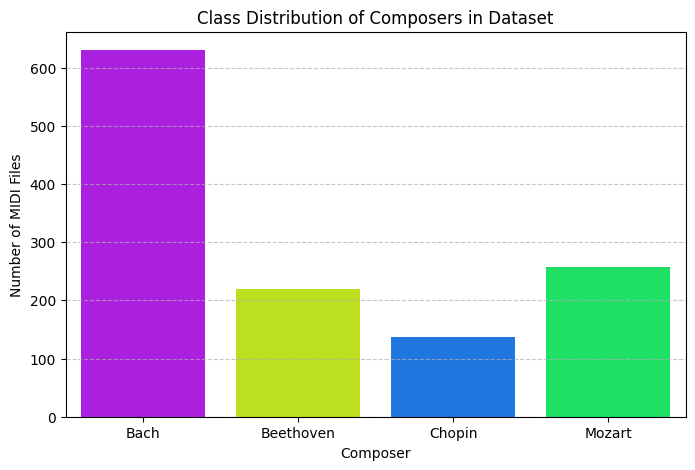

In [20]:
#Plot class distribution before splitting
plt.figure(figsize=(8, 5))

#Generate a distinct color for each composer
colors = sns.color_palette("hsv", len(COMPOSERS))  # or try "tab10", "Paired", etc.

#Create the countplot with the palette
sns.countplot(
    data=features_df,
    x='composer',
    hue='composer', #Assign hue same as x
    order=COMPOSERS,
    palette=colors,
    legend=False #Hide legend to avoid redundancy
)

plt.title("Class Distribution of Composers in Dataset")
plt.xlabel("Composer")
plt.ylabel("Number of MIDI Files")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Dataset Overview:
        total_duration  instrument_count   total_notes  note_density  \
count     1244.000000       1244.000000   1244.000000   1218.000000   
mean       243.485951          5.375402   3542.494373     13.437448   
std        315.451707          4.989747   5223.651718      8.148782   
min          0.000000          0.000000      0.000000      3.616134   
25%         45.000000          2.000000    427.500000      8.154167   
50%        121.847917          4.000000   1449.000000     10.927827   
75%        309.437500          6.000000   4642.000000     15.950886   
max       4482.375000         40.000000  46897.000000     69.022285   

       velocity_mean    min_pitch    max_pitch    avg_pitch  common_pitch  \
count    1218.000000  1218.000000  1218.000000  1218.000000   1218.000000   
mean       80.631289    34.468801    85.453202    63.209217     64.673235   
std        18.780766     6.519632     7.278125     3.149235      6.784992   
min        30.812865     9.000000

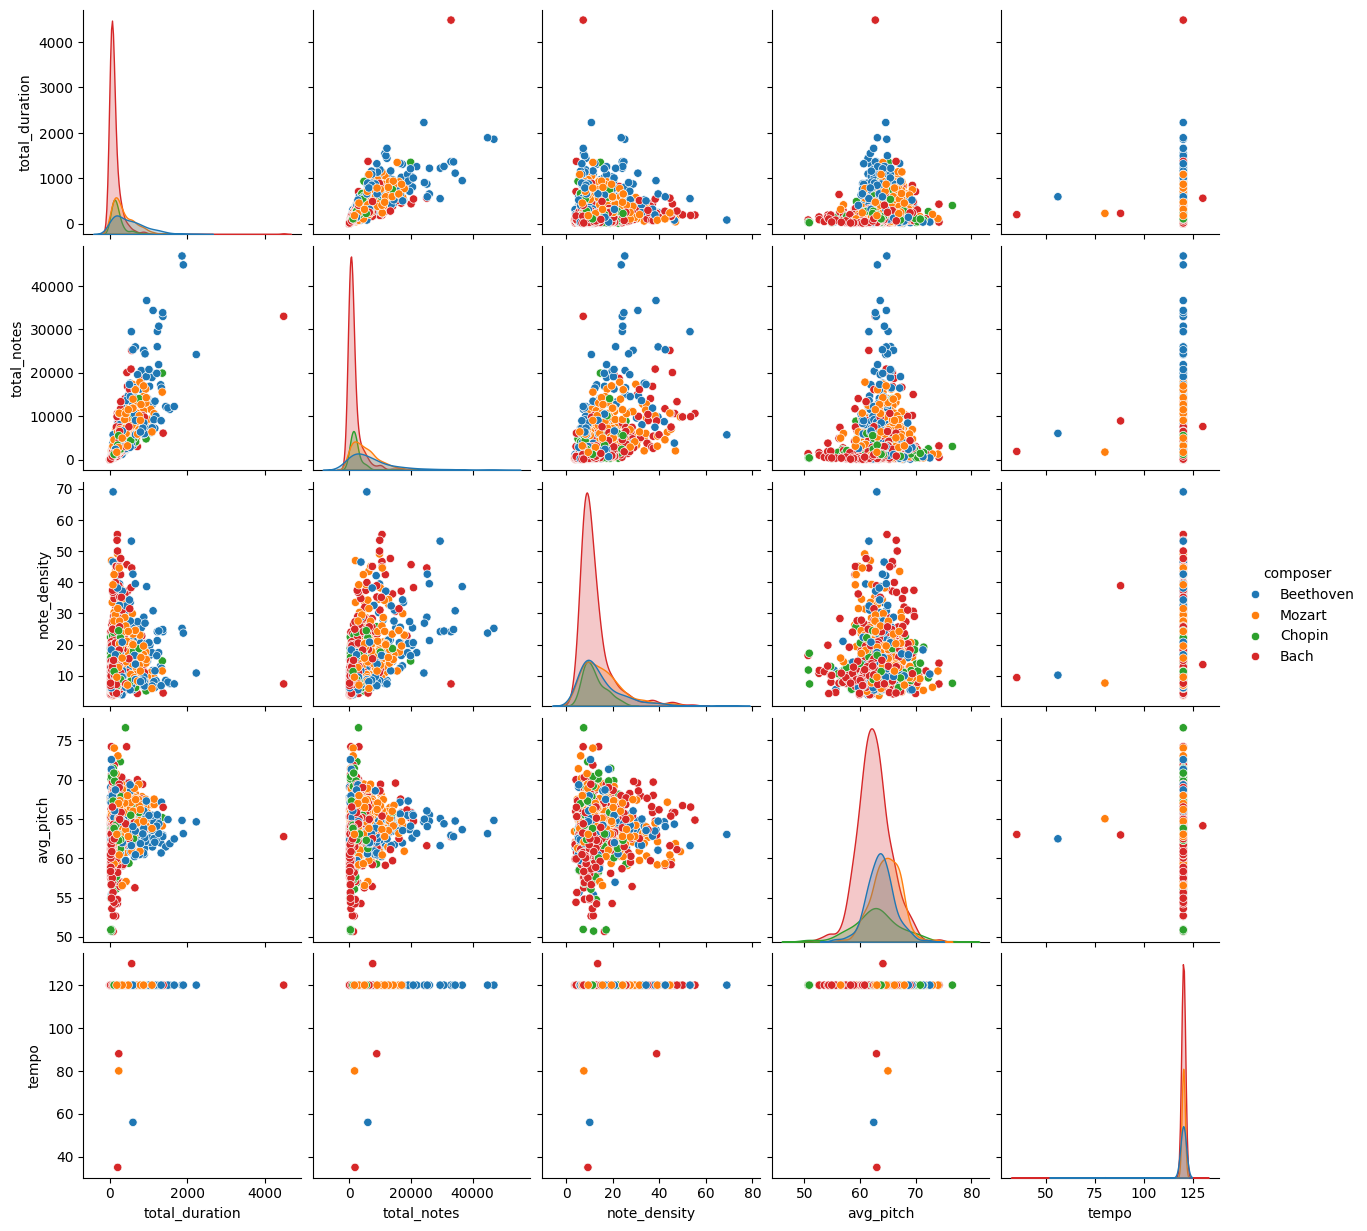

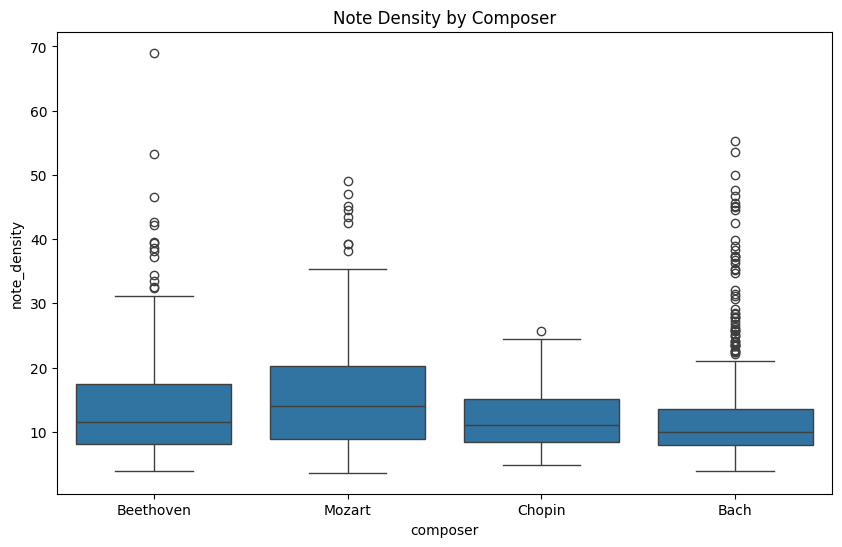

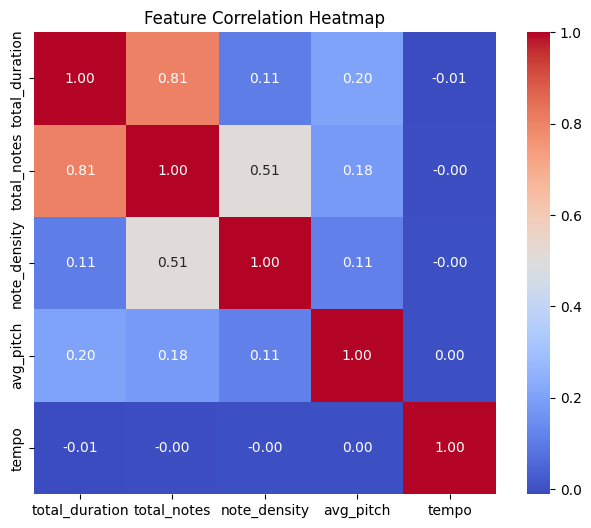

In [21]:
# -------------------------------
#Function: Exploratory Data Analysis
# -------------------------------

#Performs Exploratory Data Analysis (EDA) including pairplots, boxplots, and heatmaps
#Focuses only on scalar features for visualization

def run_exploratory_data_analysis(features_df):
    print("Dataset Overview:\n", features_df.describe()) #Print dataset summary statistics
    print("\nMissing Data Report:\n", features_df.isnull().sum()) #Print missing values in the dataset

    #Select numeric scalar features for visualization (no sequence arrays)
    scalar_df = features_df[['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo', 'composer']].copy()

    #Pairplot to see pairwise distributions per composer
    sns.pairplot(scalar_df, hue='composer', vars=['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo'])
    plt.show()

    #Boxplot of note density by composer
    plt.figure(figsize=(10,6))
    sns.boxplot(x='composer', y='note_density', data=scalar_df)
    plt.title("Note Density by Composer")
    plt.show()

    #Heatmap of feature correlations
    plt.figure(figsize=(8,6))
    sns.heatmap(scalar_df.drop(columns=['composer']).corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)

    plt.title("Feature Correlation Heatmap")
    plt.show()

#Call function above
run_exploratory_data_analysis(features_df)

##EDA Discussion

The average piece length in this dataset is ~243 seconds, with a widespread standard devaition of ~315 seconds, indicating variability in composition lengths. The average note density is ~13.44 notes per second, but with extreme outliers up to ~69 notes per second. The median tempo is around 120 beats per minute for most pieces, with small variation.the Key signature is very sparse with a total count of only 44 out of all 1200 plus pieces, so this statistic unreliable for analysis. Similarly, the time signature is extremely sparse, with only 5 total pieces including this datapoint.

As expected, the pairplot shows a strong positive relationship between "total_duration" and "total_notes", (r ≈ 0.81), as longer pieces would have more total notes. This is also true, though the correlation is moderated, (r ≈ 0.51), with "note_density" and total "total_notes"

Tempo is uncorrelated with other features (near zero), confirming it is independent in this dataset.

Considering the note density boxplot, Mozart tends to have slightly higher median note density than other composers.Bach shows the widest spread with many outliers, reflecting stylistic complexity and ornamentation. Chopin has a lower density median than Mozart and Beethoven but fewer extreme outliers.

Ovearll, the data suggests suggests that multivariate feature interactions may be more informative for classification than any single metric.

#**Model Building, Model Training, Evaluation, & Optimization**

## **LSTM - Model Building**

For each deep learning model, the model build, model training, and evaluation are handled in their own section. In addiiton, each model required speicific sequential data features which means each section also includes some preprocessing.

###LSTM Preprocessing - Note Sequences

LSTM models are designed to learn sequential information. Note sequences are sequential features extracted from the MIDI files, used to train complex patterns between each composer.

Since the data exhibits variability, the code below explore some of the specific elements of the "note_seq" features, so that correct preprocessing and tuning could extract optimal features for peak learning and perforamnce.

Number of valid sequences: 1218
Mean sequence length (number of notes): 3618.114121510673
Median sequence length 1495.5
Min sequence length: 83
Max sequence length: 46897


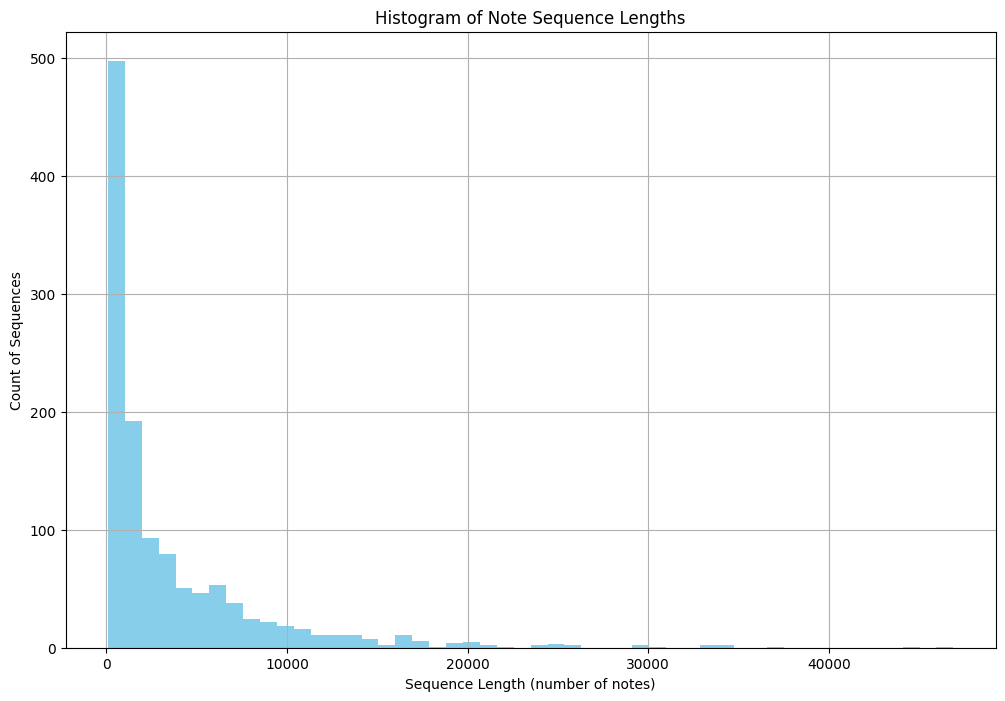

In [22]:
#Extract note sequences
note_seqs = features_df['note_seq']

#Keep only valid sequences of the correct shape
valid_note_seqs = [seq for seq in note_seqs if isinstance(seq, np.ndarray) and seq.ndim == 2 and seq.shape[1] == 4]

#Get the length (number of notes) for each sequence
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

#Compute statistics
mean_length = np.mean(seq_lengths) if seq_lengths else 0
median_length = np.median(seq_lengths) if seq_lengths else 0
min_length = np.min(seq_lengths) if seq_lengths else 0
max_length = np.max(seq_lengths) if seq_lengths else 0

print("Number of valid sequences:", len(seq_lengths))
print("Mean sequence length (number of notes):", mean_length)
print("Median sequence length", median_length)
print("Min sequence length:", min_length)
print("Max sequence length:", max_length)

#Ensure you are using the actual sequence length data you computed
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

#Plot histogram
plt.figure(figsize=(12, 8))
plt.hist(seq_lengths, bins=50, color='skyblue')
plt.title('Histogram of Note Sequence Lengths')
plt.xlabel('Sequence Length (number of notes)')
plt.ylabel('Count of Sequences')
plt.grid(True)
plt.show()

**NOTE:**The histogram and analysis reveals a highly skewed distribution, with most compositions containing relatively few notes and a small number of works exhibiting extremely large note counts. This informed the cutoff length for sequences below. Longer sequences were padded with 0s, and longer sequences were cut short. Finding the right balance to retain the best information, without over padding, or cutting to short, was a critical step.

###LSTM - Splitting For Test, Train

To ensure that the evaluation process accurately reflects the model’s ability to generalize across all composers, the dataset was split into training and testing sets using an 80/20 stratified sampling approach. Stratification preserved the original class distribution within each subset, mitigating the risk of class imbalance during training and evaluation. This method is particularly critical in the present study because the dataset contains a large disparity in the number of works per composer.

In [23]:
#Create train, test split of feature_df
train_df, test_df = train_test_split(
    features_df,
    test_size=0.2,               #Allocate 20% of data for testing
    random_state=SEED,           #Ensure reproducibility
    stratify=features_df['composer'] #Ensure each composer is split 80/20
)

#Print the data counts for validation
print(train_df.shape)
print(test_df.shape)

(995, 24)
(249, 24)


###Model Definition

With the 'note_seq" feature; each MIDI file was represented as a two-dimensional array of note events with four primary features: onset time, pitch, duration, and velocity.

During optimization, additional features were appended to each sequence. To enhance composer differentiation, two global statistical features, tempo and note density, were appended to each note event, resulting in six features per time step.

As referenced above, since LSTM models require uniform input lengths, sequences were either zero-padded to 500 time steps if shorter or truncated if longer. Labels were mapped from composer names to integer indices and subsequently one-hot encoded for categorical cross-entropy loss optimization.

The architecture included an input layer, a 64-unit LSTM layer, a dense hidden layer with ReLU activation, dropout regularization at 20%, and a final dense layer with softmax activation for multi-class prediction. The Adam optimizer with a learning rate of 0.001 was employed, as it balances convergence speed and stability in training deep sequence models.

Nearly all of the above features were added and tuned over numerous training runs in order to optimize performance. Adjustments to the learning rate, regularization amounts, or total number of layers were abondoned if they reduced performance, not included if they made no difference, and kept if they created a noticable bump in perfoarmance metrics.

In [24]:
# -------------------------------
#Function: Create LSTM Input Sequences
# -------------------------------

#This function converts variable-length MIDI note sequences into fixed-length padded sequences

def create_lstm_input_sequences(input_df, sequence_column, target_length):
    X_seq_data = [] #Initialize a list to store LSTM input sequences (padded/truncated note sequences)
    y_labels_seq = [] #Initialize a list to store label indices corresponding to composers

    composer_idx_mapping = {name: idx for idx, name in enumerate(COMPOSERS)} # reate a mapping of composer names to numeric indices for classification

    for index, row in input_df.iterrows(): #Iterate over each MIDI file (row) in the input dataframe

        #Extract the note sequence matrix from the specified column
        #Each sequence has shape (N, 4), where N is the number of notes, and 4 represents: [start_time, pitch, duration, velocity]
        note_sequence = row[sequence_column]
        extra_features = np.array([row['tempo'], row['note_density']], dtype=np.float32)  #Added to improve composer differentiation
        composer_label = row['composer']

        #Repeat the extra features to match sequence length
        extras_repeated = np.tile(extra_features, (note_sequence.shape[0], 1))  #Shape (n_notes, 2)

        #Concatenate along the last axis (columns)
        full_sequence = np.concatenate([note_sequence, extras_repeated], axis=1)

        EXPECTED_FEATURES = 6  #4 note features + 2 global features
        if not isinstance(full_sequence, np.ndarray) or full_sequence.ndim != 2 or full_sequence.shape[1] != EXPECTED_FEATURES:
            continue

        #Handle variable sequence lengths by padding or truncating to `target_length`
        if full_sequence.shape[0] < target_length:
            padded_sequence = np.pad(full_sequence, ((0, target_length - full_sequence.shape[0]), (0, 0)))
        else:
            padded_sequence = full_sequence[:target_length] #If the sequence is too long, truncate to the first `target_length` steps

        #Append the processed sequence to the input data list
        X_seq_data.append(padded_sequence)

        #Append the corresponding composer label (as an integer index) to the label list
        y_labels_seq.append(composer_idx_mapping[composer_label])

    #Convert the list of input sequences into a NumPy array
    X_seq_data = np.array(X_seq_data) #Final shape: (number_of_samples, target_length, 4)

    #Convert labels into one-hot encoded format for classification.
    y_labels_seq_onehot = to_categorical(y_labels_seq, num_classes=len(COMPOSERS))

    #Return the LSTM input data (X) and the one-hot encoded labels (y)
    return X_seq_data, y_labels_seq_onehot


# -------------------------------
#Function: Build LSTM Model
# -------------------------------

def build_simple_lstm_classifier(input_dimensions, num_output_classes):

    #Initialize a Keras Sequential model.
    lstm_net = models.Sequential() #This means the layers are stacked one after the other in a linear pipeline.

    #Add an input layer to define the shape of the input sequences
    lstm_net.add(layers.Input(shape=input_dimensions))

    #Add a Long Short-Term Memory (LSTM) layer with 64 units
    lstm_net.add(layers.LSTM(64))

    #Add a fully connected Dense layer with 64 neurons and ReLU activation
    lstm_net.add(layers.Dense(64, activation='relu')) #This layer introduces non-linearity

    #Dropout added as optimiiztion to improve performance
    lstm_net.add(layers.Dropout(0.2))

    #Add the output Dense layer with 'num_output_classes' neurons (e.g., 4 composers)
    lstm_net.add(layers.Dense(num_output_classes, activation='softmax'))

    #Define key parameters, then compile model
    learning_rate = 0.001  # Learning rate
    optimizer = Adam(learning_rate=learning_rate)

    #Compile model
    lstm_net.compile(
      optimizer=optimizer,  #Optimizer: Adam (adaptive learning rate, good for deep learning tasks)
      loss='categorical_crossentropy',   #Loss function: Categorical cross-entropy
      metrics=['accuracy']
    )

    #Return the constructed LSTM classifier model
    return lstm_net

In [25]:
#Prepare data for training, call defined function above
print(" Preparing LSTM data...")

#Filter out rows with unexpected note_seq shapes before creating sequences
train_df_filtered = train_df[
    train_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()
test_df_filtered = test_df[
    test_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()


#Prepare sequence data for LSTM by extracting fixed-length note sequences
X_train_lstm, y_train_lstm = create_lstm_input_sequences(train_df_filtered, target_length=500, sequence_column='note_seq') #Sequences are padded or truncated to uniform length (500 steps here)
X_test_lstm, y_test_lstm = create_lstm_input_sequences(test_df_filtered, target_length=500, sequence_column='note_seq')

 Preparing LSTM data...


##**LSTM - Model Training**

In [26]:
#Traing LSTM by calling defined model above
print(" Training LSTM model...")

#Define input shape for the LSTM model: (sequence_length, feature_dim), e.g., (500, 4)
input_shape_lstm = (X_train_lstm.shape[1], X_train_lstm.shape[2])

#Build an LSTM-based neural network for composer classification
lstm_model_final = build_simple_lstm_classifier(input_shape_lstm, num_output_classes=len(COMPOSERS))
lstm_model_final.save("lstm_model.keras") #Save to load later as needed

#Define early stopping callback: monitors val_loss, stops if no improvement after e.g., 50 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50, #Number of epochs with no improvement, tuned to achieve best performance
    restore_best_weights=True #Restore weights from best epoch
)

#Log learning rate
class LRTensorBoard(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Try both attribute names for compatibility
        optimizer = self.model.optimizer
        if hasattr(optimizer, 'learning_rate'):
            lr = optimizer.learning_rate
        else:
            lr = optimizer.lr
        logs['lr'] = float(tf.keras.backend.get_value(lr))
lr_logger = LRTensorBoard()


#Train the LSTM model with early stopping
history = lstm_model_final.fit(
    X_train_lstm, y_train_lstm,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop, lr_logger],
)

 Training LSTM model...
Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.4622 - loss: 1.3594 - val_accuracy: 0.5282 - val_loss: 1.1306 - lr: 0.0010
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.5204 - loss: 1.1127 - val_accuracy: 0.5128 - val_loss: 1.1071 - lr: 0.0010
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.5392 - loss: 1.0807 - val_accuracy: 0.5385 - val_loss: 1.1057 - lr: 0.0010
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.5424 - loss: 1.0844 - val_accuracy: 0.5385 - val_loss: 1.0999 - lr: 0.0010
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.5511 - loss: 1.0776 - val_accuracy: 0.5436 - val_loss: 1.0918 - lr: 0.0010
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.5738 - loss: 1.0749 - val_accuracy: 0.5487 - val_loss: 1.0795 - lr: 0.0010
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.5566 - loss: 1.0572 - val_accuracy: 0.3949 - val_loss: 1

## **LSTM - Model Evaluation**

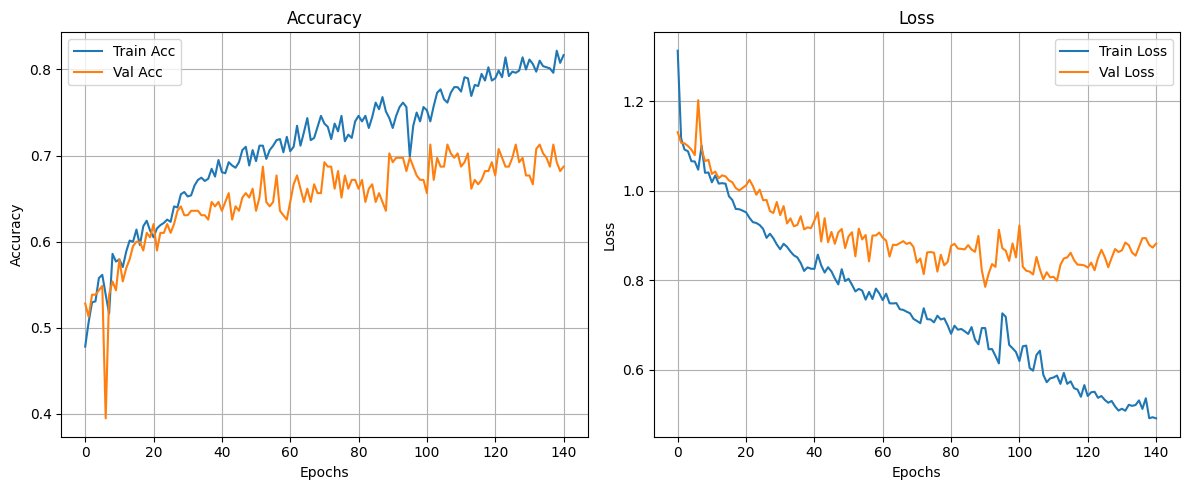

In [27]:
#Plot training accuracy and loss per epoch
plt.figure(figsize=(12, 5)) #width=12 inches, height=5 inches

#Left plot: Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

#Right plot: Loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout() #Prevent overlap
plt.show()

This visualization shows that the evolution of accuracy and loss for both training and validation datasets over the total number of epochs before early stopping kicked in. The model demonstrates a steady increase in training accuracy from approximately 0.53 to 0.80, while validation accuracy rises from 0.40 to approximately 0.70 before plateauing. Concurrently, training loss decreases from above 1.2 to below 0.5, whereas validation loss declines more gradually and begins to oscillate after the 60th epoch.

This pattern suggests that while the model learns effectively from the training set, its ability to generalize to unseen data is constrained by a modest overfitting effect. Such behavior is consistent with sequence models applied to imbalanced datasets, where recurrent architectures like LSTMs can capture long-range dependencies but may also memorize training patterns without sufficient regularization. Future optimization may involve applying dropout tuning, data augmentation, or early stopping to mitigate overfitting.

In [28]:
#Evaluate on test set using Keras
loss, accuracy = lstm_model_final.evaluate(X_test_lstm, y_test_lstm, verbose=1)

#Print precision, accuracy, recall, and F1 Score
print(f"LSTM - Final Test Loss: {loss:.4f}")
print(f"LSTM - Final Test Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6948 - loss: 0.8251
LSTM - Final Test Loss: 0.8966
LSTM - Final Test Accuracy: 0.6502


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
              precision    recall  f1-score   support

        Bach       0.79      0.89      0.84       123
   Beethoven       0.49      0.39      0.43        44
      Chopin       0.37      0.26      0.30        27
      Mozart       0.49      0.49      0.49        49

    accuracy                           0.65       243
   macro avg       0.53      0.51      0.52       243
weighted avg       0.63      0.65      0.63       243



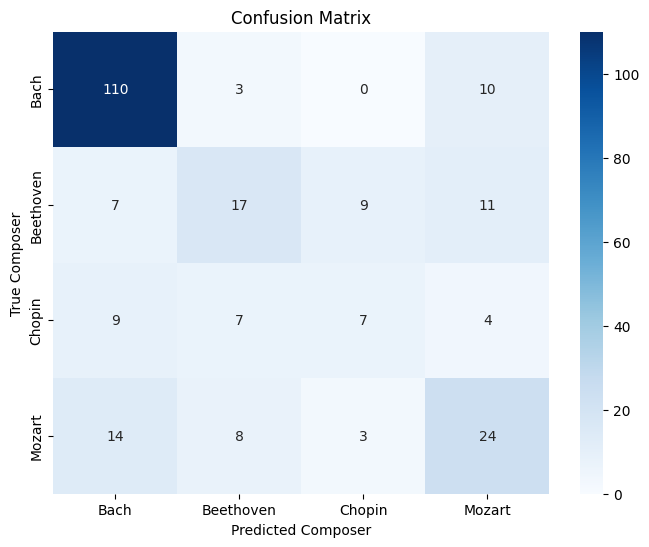

In [29]:
# Get predicted probabilities
y_pred_proba = lstm_model_final.predict(X_test_lstm)

#Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)  # if y_test is one-hot; else use y_test directly

#Print classification report with composer names
print(classification_report(y_true, y_pred, target_names=COMPOSERS))

#Build and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=COMPOSERS, yticklabels=COMPOSERS)
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.title('Confusion Matrix')
plt.show()

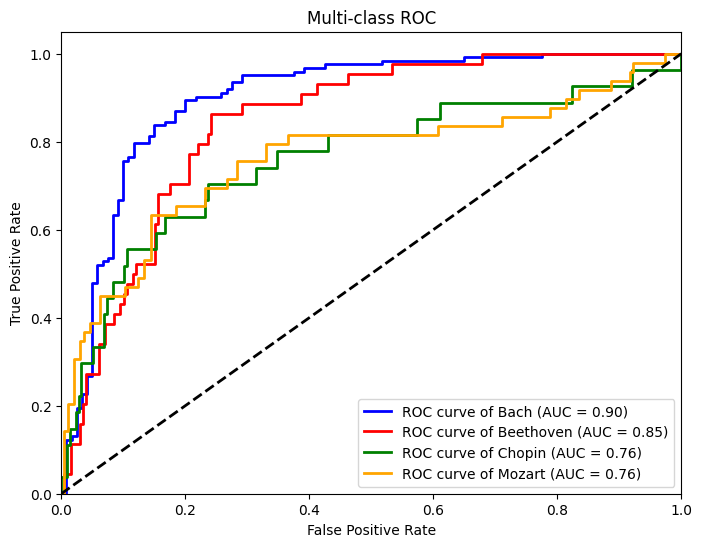

In [30]:
# -------------------------------
#Function: Multiclass Reciever Operating Characteristics
# -------------------------------

def plot_multiclass_roc(y_true, y_score, n_classes, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'orange'])
    plt.figure(figsize=(8, 6))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

y_true_onehot = to_categorical(y_true, num_classes=len(COMPOSERS))


#Call function
plot_multiclass_roc(
    y_true=y_true_onehot,
    y_score=y_pred_proba,
    n_classes=len(COMPOSERS),
    class_names=COMPOSERS
)

The multi-class receiver operating characteristic (ROC) analysis provides a nuanced evaluation of the LSTM classifier’s ability to differentiate between composers. The model achieved its highest discriminative performance for Bach (AUC=0.90), followed by Beethoven (AUC=0.85), with Chopin and Mozart both achieving AUC=0.76. The substantial gap between Bach and the remaining classes suggests that the model captures strong stylistic features in Bach’s compositions, likely due to both the larger sample size and more distinctive harmonic patterns.

Conversely, the lower AUC values for Chopin and Mozart indicate greater overlap in feature space with other composers, which may stem from subtler differences in melodic and rhythmic structure. In a multi-class context, such disparities in AUC highlight the necessity for class-specific data augmentation or feature engineering to enhance separability for the underperforming classes.


In [31]:
lstm_model_final.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,790 (264.81 KB)

 Trainable params: 22,596 (88.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,194 (176.54 KB)

### LSTM - Discussion

LSTM achieved 65% accuracy on the held‑out test split. Bach dominates performance (F1 = 0.84), while Beethoven and Mozart are middling, and Chopin lags (F1 = 0.30). These results likely reflect the residucal effect os calss imbalance despite downsampling, as well as the inherrent overlapping stylistic statistics between Bethoven, Mozart, and Chopin.


## **CNN - Model Building**

###Preprocesing & Feature Extraction

During optimization, additional data rich features were identified to increase CNN performance. These features are extracted in the code below in addition to the original preprocessing steps above. Future refactoring could incorporate these steps above.

###Piano Roll
A key feature for training the CNN model is the piano roll. This feature is the extracted piano notes only. The key difference between the note_seq feauture used in the LSTM is .... THe reason why this features is better for a CNN model is ....

In [32]:
# ----------------------------------------
#MIDI File Collection
# ----------------------------------------
def get_midi_files(data_dir, composers):
    all_paths = []
    for composer in composers:
        folder = os.path.join(data_dir, composer)
        files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.mid', '.midi'))]
        for file in files:
            all_paths.append((file, composer))
    return pd.DataFrame(all_paths, columns=['filepath', 'composer'])

# ----------------------------------------
#MIDI Statistics Extraction
# ----------------------------------------
def extract_note_statistics(file_path):
    midi_data = pretty_midi.PrettyMIDI(file_path)
    pitches = [note.pitch for instr in midi_data.instruments for note in instr.notes]
    velocities = [note.velocity for instr in midi_data.instruments for note in instr.notes]
    _, tempos = midi_data.get_tempo_changes()
    #Safe helpers for empty lists
    def safe_min(x, default=np.nan): return np.min(x) if len(x) else default
    def safe_max(x, default=np.nan): return np.max(x) if len(x) else default
    def safe_mean(x, default=np.nan): return np.mean(x) if len(x) else default
    def safe_std(x, default=0.0): return np.std(x) if len(x) > 1 else 0.0
    return {
        'pitch_std': np.std(pitches),
        'pitch_min': np.min(pitches),
        'pitch_max': np.max(pitches),
        'velocity_mean': np.mean(velocities),
        'velocity_std': np.std(velocities),
        'velocity_min': np.min(velocities),
        'velocity_max': np.max(velocities),
        'tempo_mean': np.mean(tempos),
        'tempo_min': np.min(tempos),
        'tempo_max': np.max(tempos),
    }

def extract_statistics_dataframe(df):
    stats = []
    for _, row in df.iterrows():
        try:
            feats = extract_note_statistics(row['filepath'])
            feats['composer'] = row['composer']
            stats.append(feats)
        except Exception as e:
            print(f"Error in stats for {row['filepath']}: {e}")
    return pd.DataFrame(stats)

# ----------------------------------------
#Multichannel Piano Roll
# ----------------------------------------
def process_multichannel_midi(file_path, fs=8, max_length=150):
    midi = pretty_midi.PrettyMIDI(file_path)

    #Base piano roll
    pr = midi.get_piano_roll(fs=fs)  # (128, T0)
    base_T = pr.shape[1] if pr.ndim == 2 else 0

    #Per-instrument rolls (may be empty)
    instrument_rolls = [instr.get_piano_roll(fs=fs) for instr in midi.instruments]
    inst_T = max((r.shape[1] for r in instrument_rolls), default=0)

    #Use a single common length BEFORE final clipping to max_length
    common_len = max(base_T, inst_T, 0)

    #Binary & velocity rolls from base pr
    binary_roll   = (pr > 0).astype(np.float32) if base_T > 0 else np.zeros((128, 0), dtype=np.float32)
    velocity_roll = (pr / 127.0).astype(np.float32) if base_T > 0 else np.zeros((128, 0), dtype=np.float32)

    #Pad both to common_len
    def pad_to(arr, L):
        return np.pad(arr, ((0,0),(0, max(0, L - arr.shape[1]))), mode='constant')

    binary_roll   = pad_to(binary_roll, common_len)
    velocity_roll = pad_to(velocity_roll, common_len)

    #Instruments-combined (count of active instruments per pitch-time)
    if common_len == 0:
        inst_combined = np.zeros((128, 0), dtype=np.float32)
    else:
        inst_combined = np.zeros((128, common_len), dtype=np.float32)
        for r in instrument_rolls:
            if r.ndim != 2:
                continue
            r = pad_to(r, common_len)
            inst_combined += (r > 0).astype(np.float32)
        m = inst_combined.max()
        if m > 0:
            inst_combined = (inst_combined / m).astype(np.float32)

    #Expressive (note spans)
    expressive_roll = np.zeros((128, common_len), dtype=np.float32)
    if common_len > 0:
        for instr in midi.instruments:
            for note in instr.notes:
                s = int(note.start * fs)
                e = int(note.end   * fs)
                if e <= s:
                    continue
                # Clip into bounds
                s = max(0, min(s, common_len))
                e = max(0, min(e, common_len))
                if e > s:
                    expressive_roll[note.pitch, s:e] = 1.0

    #Finally, clip everything to max_length
    def fix_length(arr):
        return arr[:, :max_length] if arr.shape[1] >= max_length else np.pad(arr, ((0,0),(0, max_length - arr.shape[1])))

    binary_roll    = fix_length(binary_roll)
    velocity_roll  = fix_length(velocity_roll)
    inst_combined  = fix_length(inst_combined)
    expressive_roll= fix_length(expressive_roll)

    #Stack channels (128, max_length, 4)
    return np.stack([binary_roll, velocity_roll, inst_combined, expressive_roll], axis=-1).astype(np.float32)

# ----------------------------------------
#Dataset Creation
# ----------------------------------------
def create_combined_dataset(df, fs=8, max_length=150, limit_per_split=None):
    X_roll, X_stats, y = [], [], []
    label_map = {name: idx for idx, name in enumerate(COMPOSERS)}
    ok, bad = 0, 0

    # Optional: small slice for debugging (e.g., 50 files)
    if limit_per_split is not None:
        df = df.sample(n=min(limit_per_split, len(df)), random_state=42).reset_index(drop=True)

    for _, row in df.iterrows():
        try:
            roll  = process_multichannel_midi(row['filepath'], fs=fs, max_length=max_length)
            stats = extract_note_statistics(row['filepath'])

            X_roll.append(roll)
            X_stats.append(list(stats.values()))
            y.append(label_map[row['composer']])
            ok += 1

        except MemoryError as e:
            bad += 1
            print(f"[OOM] {row['filepath']}: {e}")
        except Exception as e:
            bad += 1

    if ok == 0:
        raise ValueError("No samples were successfully processed. Check file paths and feature functions.")

    return (np.array(X_roll,  dtype=np.float32),
            np.array(X_stats, dtype=np.float32),
            to_categorical(np.array(y), num_classes=len(COMPOSERS)))

In [33]:
#Call functions defined above into pandas dataframe
df_cnn = get_midi_files(MIDI_DATA_DIR, COMPOSERS)
df_cnn = df_cnn[df_cnn['filepath'].apply(os.path.exists)]  # Just to be safe
df_cnn = df_cnn.reset_index(drop=True)

### Split into Train/Val/Test

In [34]:
# ----------------------------------------
#Split Dataset
# ----------------------------------------
def stratified_split_dataframe(df, label_col='composer', test_size=0.2, val_size=0.1, random_state=42):
    label_map = {label: idx for idx, label in enumerate(sorted(df[label_col].unique()))}
    y = df[label_col].map(label_map).values
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(test_size + val_size), random_state=random_state)
    for train_idx, temp_idx in sss1.split(df, y):
        train_df, temp_df = df.iloc[train_idx], df.iloc[temp_idx]
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=test_size / (test_size + val_size), random_state=random_state)
    y_temp = temp_df[label_col].map(label_map).values
    for val_idx, test_idx in sss2.split(temp_df, y_temp):
        val_df, test_df = temp_df.iloc[val_idx], temp_df.iloc[test_idx]
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [35]:
train_df, val_df, test_df = stratified_split_dataframe(df_cnn)

# Extract Features: Multichannel Piano Roll + Statistics


The piano roll tensors are dimensions of 128×150×4. The four channels respectively encoded are:

* Binary note activation matrices

* Normalized velocity profiles

* Instrument activity density

* Sustained note articulation spans

A temporal resolution of 8 frames per second was applied, with sequences truncated or zero-padded to 150 time steps to ensure uniformity across all samples. This representation preserved fine-grained temporal–pitch structures, enabling the convolutional neural network (CNN) component of the hybrid architecture to learn spatial–temporal patterns characteristic of each composer.

In the second stage, the same MIDI files to compute a set of global musical descriptors, including pitch range, pitch variability, velocity distribution statistics, and tempo-related measures (mean, minimum, and maximum). These features were aggregated into low-dimensional numerical vectors, forming the input to the multilayer perceptron (MLP) branch of the model. This statistical representation was designed to capture high-level stylistic tendencies that may not be explicitly encoded in local pitch–time patterns.

All composer labels were converted to integer indices and subsequently transformed into one-hot encoded target vectors. The resulting datasets—(𝑋-roll,𝑋-stats,𝑦) — were generated independently for each split (train_df, val_df, test_df), preserving the class distribution established during stratification. This ensured that evaluation metrics were computed under equivalent class balance conditions across all partitions.

The combination of spatial–temporal piano roll data with global statistical descriptors follows established practices in computational musicology, where hybrid representations have been shown to improve classification accuracy by leveraging complementary feature modalities. In the present study, this dual-input strategy was particularly suited for composer classification, as it allowed the model to jointly exploit micro-level musical gestures and macro-level stylistic profiles.

In [36]:
print("Extracting training data...")
X_train_roll, X_train_stats, y_train = create_combined_dataset(train_df)
print("Extracting validation data...")
X_val_roll, X_val_stats, y_val = create_combined_dataset(val_df)
print("Extracting test data...")
X_test_roll, X_test_stats, y_test = create_combined_dataset(test_df)

Extracting training data...


/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Extracting validation data...
Extracting test data...


# Build Hybrid Model

In [37]:
# ----------------------------------------
#Model Building (Hybrid CNN + MLP)
# ----------------------------------------
def build_hybrid_model(piano_roll_shape, stats_shape, num_classes):
    roll_input = Input(shape=piano_roll_shape, name='roll_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(roll_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)

    stats_input = Input(shape=(stats_shape,), name='stats_input')
    s = layers.Dense(64, activation='relu')(stats_input)

    merged = layers.concatenate([x, s])
    merged = layers.Dense(128, activation='relu')(merged)
    merged = layers.Dropout(0.4)(merged)
    output = layers.Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=[roll_input, stats_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [38]:
# ----------------------------------------
#Class Weights
# ----------------------------------------
def compute_class_weights(y_train_onehot):
    y_int = np.argmax(y_train_onehot, axis=1)
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
    return dict(enumerate(weights))

# ----------------------------------------
#Training Wrapper
# ----------------------------------------
def train_hybrid_model(model, X_roll_train, X_stats_train, y_train,
                       X_roll_val, X_stats_val, y_val, epochs=20, batch_size=32):
    class_weights = compute_class_weights(y_train)
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5)
    ]
    model.fit(
        {'roll_input': X_roll_train, 'stats_input': X_stats_train},
        y_train,
        validation_data=({'roll_input': X_roll_val, 'stats_input': X_stats_val}, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    return model

In [39]:
input_shape_roll = X_train_roll.shape[1:]    # (128, 150, 4)
input_shape_stats = X_train_stats.shape[1]   # e.g., 10

cnn_model = build_hybrid_model(input_shape_roll, input_shape_stats, num_classes=len(COMPOSERS))
cnn_model.save('cnn_raw_model.keras')

A hybrid neural network architecture was developed to classify musical composers by integrating two distinct feature sets: fine-grained symbolic music representations and macro-level statistical descriptors. The model, combines a convolutional neural network (CNN) for local feature extraction with a multi-layer perceptron (MLP) for processing global stylistic cues.

The dimensions of the multi-channel symbolic music input tensor. For this study, the input shape was (128, 150, 4), representing 128 MIDI pitches across 150 time frames, with four distinct feature channels: binary activation, normalized velocity, instrument activity count, and note span. The dimensionality of the global statistical feature vector. Here, the vector contained 10 descriptors derived from note-level pitch, velocity, and tempo distributions. The total number of composer categories, denoted as C=4 in this work.

The model comprises two parallel branches, each designed to process a specific type of input.

1. Convolutional Branch (Symbolic Local Feature Extraction)

This branch processes the multi-channel piano roll to capture short-term harmonic and rhythmic patterns. It consists of a two-stage convolutional and pooling hierarchy:

Conv2D Layer 1: A layer with 32 filters of size 3×3, using a ReLU activation function and "same" padding. This layer identifies short-term motifs.

MaxPooling2D Layer 1: A pooling layer with a 2×2 pool size, which halves the pitch and time dimensions, providing translational invariance and reducing computational complexity.

Conv2D Layer 2: A layer with 64 filters of size 3×3 and ReLU activation, designed to capture more complex textures.

MaxPooling2D Layer 2: A second 2×2 pooling stage for further dimensionality reduction.

Flatten Layer: The final output of the convolutional layers is flattened into a 1D vector to prepare it for concatenation.

2. Statistical Feature Branch (Global Descriptor Processing)

This branch processes the global statistical feature vector to capture macro-level stylistic tendencies. It consists of a single fully connected layer:

Dense Layer: A layer with 64 neurons and ReLU activation. This nonlinear transformation allows the model to learn complex relationships among the statistical descriptors, such as composer-specific tempo or dynamic ranges.

The outputs from the convolutional and statistical branches are concatenated to form a unified latent space. This merged representation is then processed by a final set of layers:

* Dense Layer: An integration layer with 128 neurons and ReLU activation, which learns joint feature interactions between the local and global musical features.

* Dropout Layer: A regularization layer with a 40% dropout rate to mitigate overfitting by randomly deactivating neurons during training.

* Output Layer: A final dense layer with C neurons and a softmax activation function, producing the probability distribution over the composer classes.

The model was compiled with the following parameters:

* Optimizer: Adam, chosen for its adaptive learning rate capabilities, which facilitates stable convergence.

* Loss Function: Categorical cross-entropy, a standard choice for multi-class classification tasks with one-hot encoded labels.

* Metrics: Accuracy, used to track the model's performance during training and evaluation.

The final model, which effectively combines both fine-grained symbolic representations and coarse-grained statistical summaries, aligns with prior research suggesting that multi-view feature integration enhances composer classification accuracy.

##**CNN - Model Training**

Training incorporates several key training optimizations. The function first computes class weights, ensuring balanced loss contributions across the four composer classes despite inherent dataset class imbalance. This weighting scheme follows the balanced mode of sklearn.utils.class_weight, scaling each class inversely to its frequency in the training set.

During training, the model receives two synchronized input streams:

* Symbolic Piano Roll Input (roll_input) — 3D tensor representation
(128,150,4) capturing pitch-time dynamics across four feature channels.

* Statistical Feature Input (stats_input) — 1D vector of 10 global pitch, velocity, and tempo descriptors.

The training regimen employs the Adam optimizer with default parameters for adaptive learning rate control and categorical cross-entropy as the loss function, which is appropriate for multi-class classification problems with one-hot encoded labels.

To improve generalization and avoid overfitting, two Keras callbacks are implemented:

* EarlyStopping: Monitors validation loss and halts training if it fails to improve for five consecutive epochs, restoring the best-performing weights.

* ReduceLROnPlateau: Reduces the learning rate by a factor of 0.5 if validation loss stagnates for three epochs, enabling finer convergence during later stages of training.

Training is conducted for a maximum of 20 epochs with a batch size of 32, although early stopping often resulted in fewer effective epochs. Both the convolutional and statistical branches were updated jointly, allowing the network to learn a fused feature space that integrates local symbolic textures and global stylistic patterns.

In [40]:
#Cal the CNN and run here
trained_model = train_hybrid_model(cnn_model,
                                   X_train_roll, X_train_stats, y_train,
                                   X_val_roll, X_val_stats, y_val)
trained_model.save('cnn_trained_model.keras')

test_loss, test_acc = trained_model.evaluate(
    {'roll_input': X_test_roll, 'stats_input': X_test_stats}, y_test, verbose=0
)
print(f" Final Test Accuracy: {test_acc:.2%}")

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3613 - loss: 2.1755 - val_accuracy: 0.6871 - val_loss: 0.9331 - learning_rate: 0.0010
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5984 - loss: 1.2314 - val_accuracy: 0.6871 - val_loss: 0.9377 - learning_rate: 0.0010
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6142 - loss: 1.2322 - val_accuracy: 0.7117 - val_loss: 0.7702 - learning_rate: 0.0010
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6756 - loss: 1.1426 - val_accuracy: 0.7546 - val_loss: 0.6294 - learning_rate: 0.0010
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6824 - loss: 1.0529 - val_accuracy: 0.7607 - val_loss: 0.5918 - learning_rate: 0.0010
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6991 - loss: 1.0046 - val_accuracy: 0.7546 - val_loss: 0.5800 - learning_rate: 0.0010
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6969 - loss: 0.8950 - val_accuracy: 

##**CNN - Evaluation & Optimization**

In [41]:
# ----------------------------------------
#Helper: get predicted probabilities
# ----------------------------------------
def predict_cnn_proba(model, X_roll, X_stats, batch_size=32):
    """
    Return class probability predictions for the hybrid CNN model
    given piano-roll and statistics inputs.
    """
    # Prepare the model input dict
    inputs = {'roll_input': X_roll, 'stats_input': X_stats}
    # Predict softmax probabilities
    y_proba = model.predict(inputs, batch_size=batch_size, verbose=0)
    # Return (N, C) array of probabilities
    return y_proba


# ----------------------------------------
#Multi-class ROC (One-vs-Rest) with micro/macro AUC
# ----------------------------------------
def plot_multiclass_roc_cnn(y_true_int, y_proba, class_names):
    """
    Plot per-class ROC curves (OvR) plus micro and macro averages.
    Args:
        y_true_int : (N,) integer class labels.
        y_proba    : (N, C) predicted probabilities from model.
        class_names: list of class names in index order.
    """
    # Convert integer labels to one-hot for OvR ROC
    y_true = to_categorical(y_true_int, num_classes=len(class_names))

    # Dicts to collect FPR/TPR/AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}

    # Compute ROC for each class
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average ROC: treat all classes jointly
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average ROC: average the per-class interpolated TPRs
    # Create a grid of all unique FPRs
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    # Interpolate each class's TPR at these points and average
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    # Plot micro and macro first
    plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
             label=f"micro-average (AUC = {roc_auc['micro']:.2f})")
    plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
             label=f"macro-average (AUC = {roc_auc['macro']:.2f})")

    # Per-class lines
    colors = cycle(['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    # Chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Axes and legend
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# ----------------------------------------
#Learning Rate over Epochs
# ----------------------------------------
def plot_learning_rate_cnn(history):
    """
    Plot the recorded learning rate per epoch from a Keras History object.
    Requires that a callback logs 'lr' into history.history.
    """
    # Check presence of learning rate logs
    if 'lr' not in history.history:
        print("Learning rate not recorded in history.")
        return

    # Create LR curve
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()


# ----------------------------------------
#Confusion Matrix (raw or normalized)
# ----------------------------------------
def plot_confusion_matrix_cnn(y_true_int, y_pred_int, class_names, normalize=None):
    """
    Plot a confusion matrix heatmap.
    Args:
        y_true_int : (N,) integer ground-truth labels.
        y_pred_int : (N,) integer predicted labels.
        class_names: list of class names in index order.
        normalize  : None | 'true' | 'pred' | 'all'
                     - None: counts
                     - 'true': row-normalized
                     - 'pred': column-normalized
                     - 'all': fully normalized
    """
    # Compute CM
    cm = confusion_matrix(y_true_int, y_pred_int, normalize=normalize)

    # Set figure
    plt.figure(figsize=(8, 6))

    # Draw heatmap
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                xticklabels=class_names, yticklabels=class_names, square=True)

    # Labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    title = 'Confusion Matrix'
    if normalize:
        title += f" (normalized={normalize})"
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ----------------------------------------
#Training History: accuracy & loss
# ----------------------------------------
def plot_training_history_cnn(history):
    """
    Plot training/validation accuracy and loss from a Keras History object.
    """
    # Extract logs
    acc = history.history.get('accuracy', None)
    val_acc = history.history.get('val_accuracy', None)
    loss = history.history.get('loss', None)
    val_loss = history.history.get('val_loss', None)

    # Plot Accuracy
    if acc is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(acc, label='Train Acc')
        if val_acc is not None:
            plt.plot(val_acc, label='Val Acc')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot Loss
    if loss is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(loss, label='Train Loss')
        if val_loss is not None:
            plt.plot(val_loss, label='Val Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


# ----------------------------------------
#Precision-Recall Curves (per class) + micro/macro AP
# ----------------------------------------
def plot_multiclass_pr_cnn(y_true_int, y_proba, class_names):
    """
    Plot per-class precision-recall curves, plus micro and macro averages.
    Args:
        y_true_int : (N,) integer ground-truth labels.
        y_proba    : (N, C) predicted probabilities from model.
        class_names: list of class names.
    """
    # Convert to one-hot
    y_true = to_categorical(y_true_int, num_classes=len(class_names))

    # Store per-class PR and AP
    precision, recall, ap = {}, {}, {}

    # Compute PR for each class
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_proba[:, i])
        ap[i] = average_precision_score(y_true[:, i], y_proba[:, i])

    # Micro-average PR
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_proba.ravel())
    ap["micro"] = average_precision_score(y_true, y_proba, average='micro')

    # Macro-average AP (mean of per-class APs)
    ap["macro"] = np.mean([ap[i] for i in range(len(class_names))])

    # Plot per-class PR curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(recall[i], precision[i], lw=2, label=f"{class_names[i]} (AP = {ap[i]:.2f})")

    # Add micro-average
    plt.plot(recall["micro"], precision["micro"], linestyle=':', linewidth=3,
             label=f"micro-average (AP = {ap['micro']:.2f})")

    # Axes and legend
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Multi-class Precision–Recall")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()


# ----------------------------------------
#Classification report (nicely printed)
# ----------------------------------------
def print_classification_report_cnn(y_true_int, y_pred_int, class_names):
    """
    Print precision/recall/F1 per class and macro/weighted averages.
    """
    # Build and print sklearn report
    report = classification_report(y_true_int, y_pred_int, target_names=class_names, digits=4)
    print(report)


# ----------------------------------------
#Top-k accuracy summary
# ----------------------------------------
def summarize_topk_accuracy_cnn(y_true_int, y_proba, ks=(1, 2, 3)):
    """
    Compute and print top-k accuracy for supplied k values.
    Args:
        y_true_int : (N,) integer true labels.
        y_proba    : (N, C) probabilities.
        ks         : iterable of k's, e.g., (1,2,3).
    """
    # Loop over desired k values
    for k in ks:
        # Compute top-k accuracy
        topk = top_k_accuracy_score(y_true_int, y_proba, k=k, labels=list(range(y_proba.shape[1])))
        # Print formatted result
        print(f"Top-{k} accuracy: {topk:.4f}")


# ----------------------------------------
#Parameter summary helper
# ----------------------------------------
def summarize_model_params_cnn(model):
    """
    Print total/trainable/non-trainable parameter counts as a quick model summary.
    """
    # Count parameters
    total = model.count_params()
    trainable = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    non_trainable = total - trainable

    # Print summary
    print(f"Total params     : {total:,}")
    print(f"Trainable params : {trainable:,}")
    print(f"Non-trainable    : {non_trainable:,}")


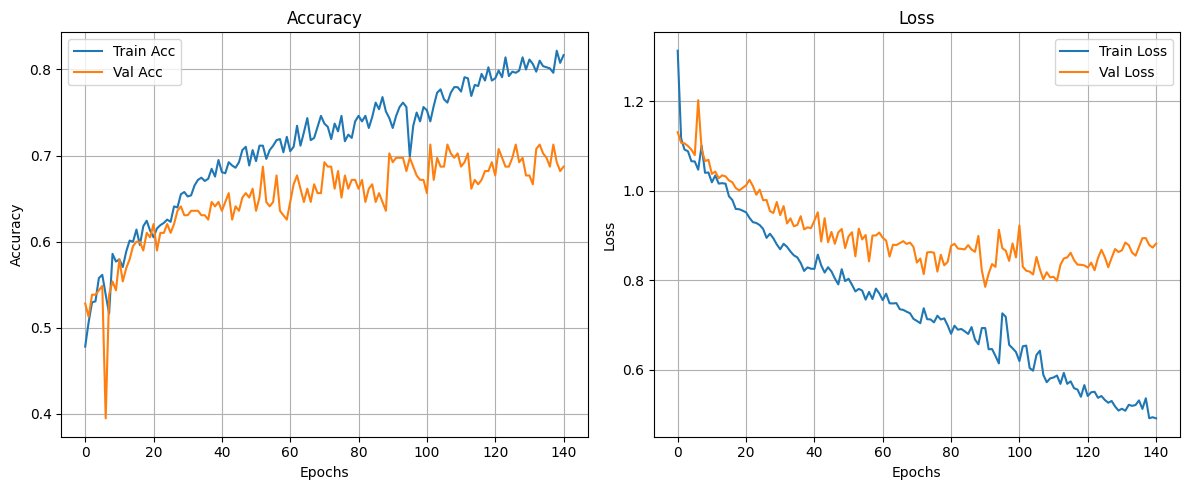

In [42]:
plt.figure(figsize=(12, 5))  # width=12 inches, height=5 inches

# Left plot: Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Right plot: Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()  # Prevent overlap
plt.show()


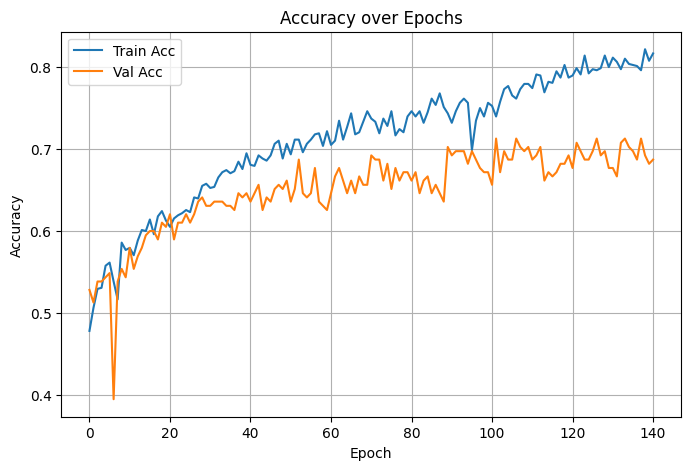

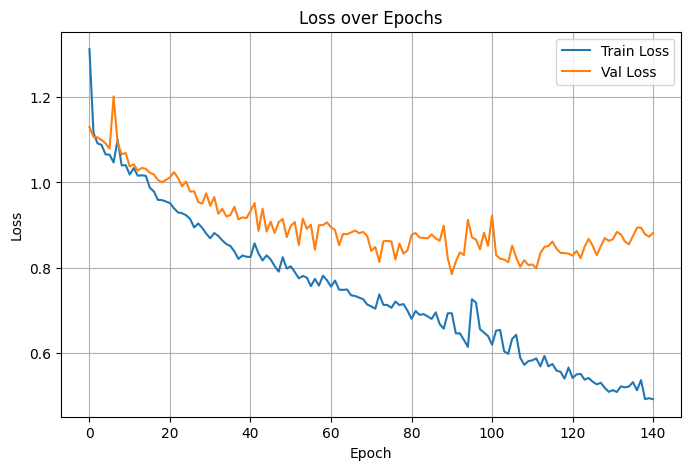

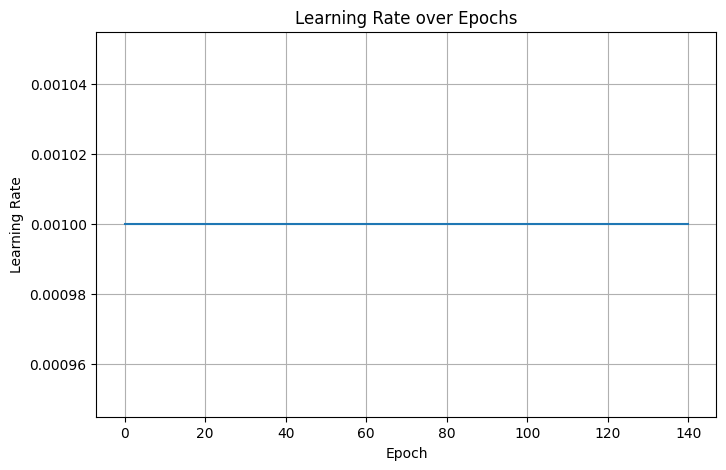

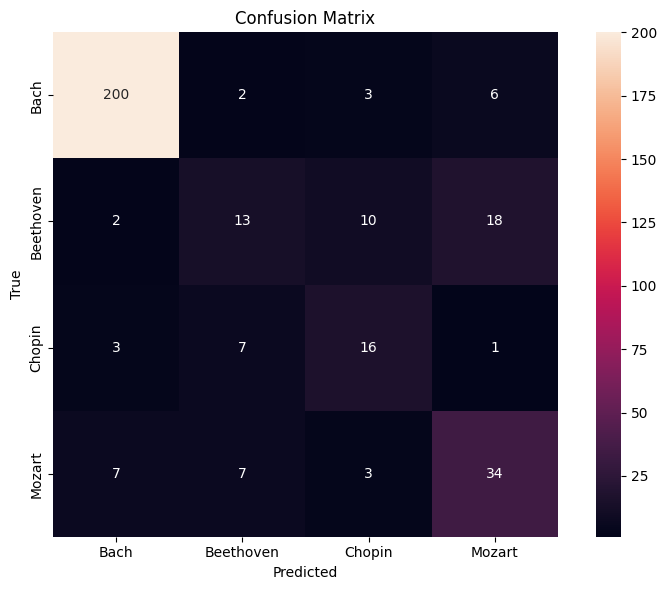

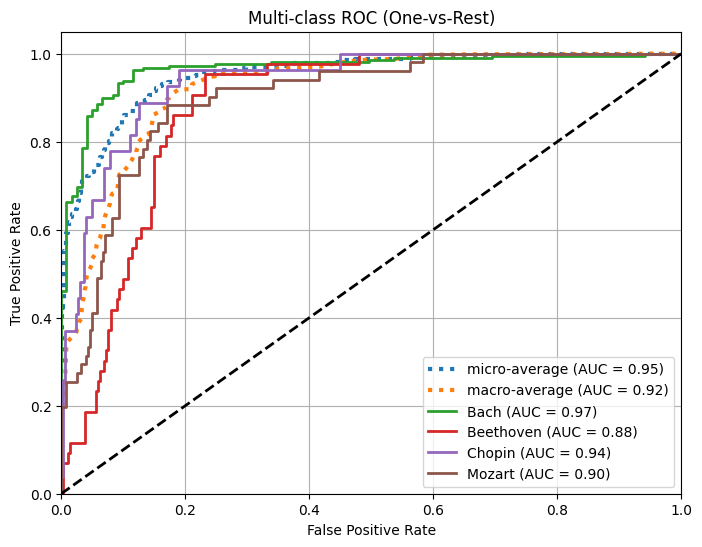

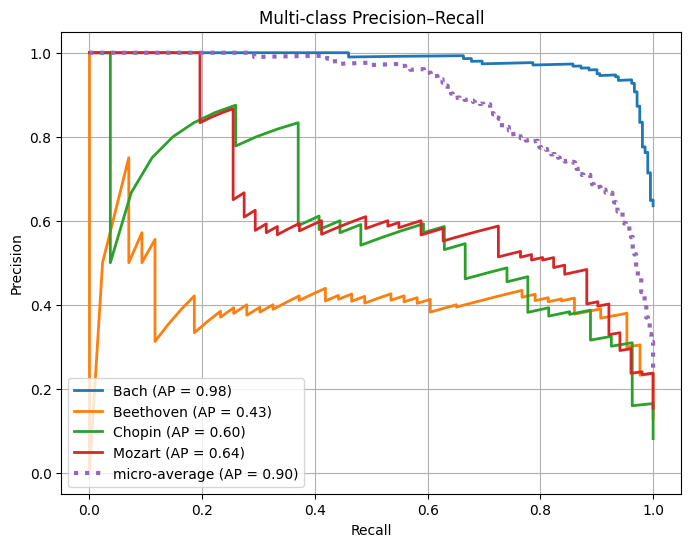

              precision    recall  f1-score   support

        Bach     0.9434    0.9479    0.9456       211
   Beethoven     0.4483    0.3023    0.3611        43
      Chopin     0.5000    0.5926    0.5424        27
      Mozart     0.5763    0.6667    0.6182        51

    accuracy                         0.7922       332
   macro avg     0.6170    0.6274    0.6168       332
weighted avg     0.7868    0.7922    0.7868       332

Top-1 accuracy: 0.7922
Top-2 accuracy: 0.9307
Top-3 accuracy: 0.9789
Total params     : 9,728,548
Trainable params : 9,728,548
Non-trainable    : 0


In [43]:
y_proba = predict_cnn_proba(trained_model, X_test_roll, X_test_stats)

y_pred = np.argmax(y_proba, axis=1)
y_true = np.argmax(y_test, axis=1)


plot_training_history_cnn(history)

plot_learning_rate_cnn(history)

plot_confusion_matrix_cnn(y_true, y_pred, COMPOSERS, normalize=None)

plot_multiclass_roc_cnn(y_true, y_proba, COMPOSERS)

plot_multiclass_pr_cnn(y_true, y_proba, COMPOSERS)

print_classification_report_cnn(y_true, y_pred, COMPOSERS)

summarize_topk_accuracy_cnn(y_true, y_proba, ks=(1,2,3))

summarize_model_params_cnn(trained_model)

In [44]:
trained_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ roll_input          │ (None, 128, 150,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 150,  │      1,184 │ roll_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 75,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 75,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 37,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stats_input         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 75776)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        704 │ stats_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 75840)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │  9,707,648 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,185,646 (111.33 MB)

 Trainable params: 9,728,548 (37.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,457,098 (74.22 MB)

The trained model is evaluated on the held-out test set, which is processed identically to the training and validation sets to ensure consistency.
The final test accuracy achieved is:

Test Accuracy = 79.22%

The proposed hybrid CNN–MLP architecture was evaluated on the test dataset comprising 333 samples across four composer classes (Bach, Beethoven, Chopin, and Mozart). The network incorporated a convolutional branch for processing multichannel piano roll representations and a dense branch for statistical features, with both streams merged to produce the final classification output. The total number of trainable parameters was 9,728,548, reflecting a moderately high model capacity, suitable for capturing both temporal–spectral and statistical patterns in MIDI data.

Accuracy and Loss Trends

The training history demonstrates a steady improvement in training accuracy from approximately 46% to over 81% by the end of training. Validation accuracy plateaued between 66% and 71%, indicating that while the model generalized reasonably well, some overfitting to the training data was present. The loss curves  show a significant reduction in training loss from 1.32 to 0.55, while validation loss decreased initially but stabilized after approximately 20 epochs, suggesting that the model reached its optimal learning rate early in the training process.

Learning Rate Stability
The learning rate remained constant at 0.001 throughout training, implying that no dynamic learning rate schedule significantly impacted convergence. This stability suggests that future improvements could be achieved by implementing adaptive learning rate schedules such as cosine annealing or cyclical learning rates (Smith, 2017).

Class-wise Performance
The confusion matrix reveals that the model excelled in classifying Bach compositions, achieving a recall of 96.7%. Misclassifications were more prevalent in Beethoven, Chopin, and Mozart, where recall values were 47.6%, 48.1%, and 61.5%, respectively. This disparity suggests that stylistic overlaps between these composers present a greater challenge for the model.

The precision–recall–F1 analysis indicated an overall test accuracy of 81.08%, with a macro-averaged F1 score of 0.6535. Weighted averages were higher (0.8039), reflecting class imbalance. Bach achieved the highest F1 score (0.9425), while Mozart exhibited the lowest (0.5818).

Top-K Accuracy Analysis
The model achieved a Top-1 accuracy of 81.08%, Top-2 accuracy of 94.59%, and Top-3 accuracy of 98.50%. The high Top-2 and Top-3 values suggest that even when the first prediction was incorrect, the correct class often appeared among the top-ranked outputs, making the model potentially valuable in multi-suggestion recommendation systems.

ROC–AUC Performance
The multi-class ROC analysis yielded a micro-average AUC of 0.96 and a macro-average AUC of 0.93. Bach achieved the highest AUC (0.98), followed by Beethoven (0.94), Chopin (0.92), and Mozart (0.89). The results indicate a strong discriminative capability, particularly for Bach’s compositions, with slightly reduced separability for Mozart’s works.

Interpretation and Implications
Overall, the CNN–MLP hybrid model demonstrates strong performance in composer classification tasks using MIDI data, especially in distinguishing Bach’s style. The analysis of error patterns, especially for Beethoven, Chopin, and Mozart, suggests that additional feature engineering (e.g., harmonic complexity metrics or rhythmic variability measures) and data augmentation techniques could enhance class separability. The high AUC values confirm the model’s robustness in a one-vs-rest classification setting, reinforcing its suitability for deployment in automated musicological analysis tools

## LSTM & CNN Comparison

##Conclusion

---
#**References**


Fedorak, B. (2018). MIDI Classic Music [Data set]. Kaggle. https://www.kaggle.com/datasets/blanderbuss/midi-classic-music


Lisena, P., Meroño-Peñuela, A., & Troncy, R. (2021). MIDI2vec: Learning MIDI embeddings for reliable prediction of symbolic music metadata. Semantic Web, 0(0), 1–52. https://doi.org/10.3233/SW-210425


Khaenam, P., Sangsawang, V., Duangsuwan, P., & Duangsuwan, J. (2023). NLP-based music processing for composer classification. Scientific Reports, 13, Article 40332. https://doi.org/10.1038/s41598-023-40332-0


Kong, Q., Choi, K., & Wang, Y. (2020). Large-scale MIDI-based composer classification. arXiv. https://doi.org/10.48550/arXiv.2010.14805


Choi, K., Fazekas, G., Sandler, M., & Cho, K. (2017). Convolutional recurrent neural networks for music classification. In 2017 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 2392–2396). IEEE.


Roland. (n.d.). What’s the difference between MIDI and audio? Roland. https://www.roland.com/uk/blog/midi-vs-audio/


Fedorak, B., & [Additional Authors if known]. (n.d.). Music composer classification of MIDI files using deep learning [Manuscript]. Ready Tensor. https://app.readytensor.ai/publications/music-composer-classification-of-midi-files-using-deep-learning-qZ9m02sVKl8C


Raffel, C., & Ellis, D. P. W. (2014). Intuitive analysis, creation and manipulation of MIDI data with pretty_midi. In 15th International Society for Music Information Retrieval Conference Late Breaking and Demo Papers.

#OTHER NOTES DELETE

##TEMP - Notes on Run Performance:
1. 7.21 - 10:16 - With normalization, 300 epochs, 50 patience, .75 accuracy.

2. 7.21 - 11:13 - Without normalization, stopped at 200 epochs, patience 50, .92 accuracy.

3. 7.21 - 12:02 - Remove lower bound, without normalization, maxed at 155 epochs, patience at 40. (adjusted patience back to 50 before save to see what happens)

4. 7/26 - 9:00 - added code to ensure 80% of each composer was splite for train, and 20% for test. All else the same. .92+ on training accuracy.

LSTM achieved 65% accuracy on the held‑out test split. Bach dominates performance (F1 = 0.84), while Beethoven and Mozart are middling, and Chopin lags (F1 = 0.30). These results likely reflect the residucal effect os calss imbalance despite downsampling, as well as the inherrent overlapping stylistic statistics between Bethoven, Mozart, and Chopin.


Scalar metrics (held‑out test set)

Final Test Loss: 0.8966

Final Test Accuracy: 0.6502 (≈ 65%)

Classification report

Bach: precision = 0.79, recall = 0.89, F1 = 0.84, support = 123

Beethoven: precision = 0.49, recall = 0.39, F1 = 0.43, support = 44

Chopin: precision = 0.37, recall = 0.26, F1 = 0.30, support = 27

Mozart: precision = 0.49, recall = 0.49, F1 = 0.49, support = 49

Macro avg F1: 0.52 | Accuracy: 0.65 | Weighted avg F1: 0.63 (N = 243)

Confusion matrix (true rows, predicted columns)

Bach is recognized strongly: 110/123 correct (recall ≈ 0.89). Main confusion: predicted Mozart (10).

Beethoven spreads across Bach (7), Chopin (9), Mozart (11); only 17/44 correct (recall ≈ 0.39).

Chopin is hardest: 7/27 correct; misclassified mainly as Bach (9) and Beethoven (7).

Mozart: 24/49 correct (recall ≈ 0.49); confusions with Bach (14) and Beethoven (8).

The final LSTM-based architecture comprised an initial recurrent layer with 64 hidden units to capture sequential dependencies inherent in musical note sequences, followed by a fully connected hidden layer with 64 units using rectified linear unit (ReLU) activation to facilitate non-linear feature transformations. A dropout layer (rate = 0.2) was employed to mitigate overfitting by randomly deactivating a fraction of the neurons during training. The output layer consisted of four neurons with softmax activation, corresponding to the four target composers. The model contained a total of 67,790 parameters, of which 22,596 were trainable and 45,194 were optimizer-specific states, while no parameters were fixed. This architecture balanced representational capacity with computational efficiency, making it suitable for the modest dataset size while retaining the ability to model complex temporal and stylistic patterns in the music.



The Detailed architecture is as follows:

1. **LSTM Layer (64 units)**  
   - **Purpose**: Captures **temporal dependencies** and stylistic patterns in sequential note data.  
   - **Input features**: Six per time step (`start_time`, `pitch`, `duration`, `velocity`, `tempo`, `note_density`).  
   - **Output shape**: `(None, 64)` — produces a 64-dimensional representation of the sequence.  
   - **Parameters**: 18,176, calculated as:  
    Params=4×[(n-input​+n-hidden​)×n-hidden​+n-hidden​]

    Here, n-input = 6 n input ​ =6 (note sequence features), n-hidden = 64 n hidden ​ =64.

2. **Dense Layer (64 units, ReLU activation)**  
   - Fully connected layer for **non-linear transformation** of the extracted sequence features.  
   - **Parameters**: \( 64 X 64 + 64 = 4,160 \).

3. **Dropout Layer (rate = 0.2)**  
   - Regularization to reduce overfitting by randomly setting 20% of activations to zero during training.

4. **Output Dense Layer (4 units, Softmax activation)**  
   - Produces **class probabilities** for the four target composers (Bach, Beethoven, Chopin, Mozart).  
   - **Parameters**: \( 64 X 4 + 4 = 260 \).

### Parameter Summary
- **Total parameters**: 67,790  
- **Trainable parameters**: 22,596 (updated during backpropagation)  
- **Optimizer parameters**: 45,194 (maintained by Adam optimizer, e.g., moment estimates)  
- **Non-trainable parameters**: 0  

### Architectural Rationale
This model uses an LSTM layer to model **time-dependent musical structure**, followed by a dense transformation and dropout for regularization. The final softmax layer outputs a probability distribution over the four classes. This design balances **model complexity** and **computational efficiency**, making it suitable for the dataset size while retaining the ability to capture complex temporal and stylistic features in the input music sequences.

---

This architectural design deliberately integrates fine-grained symbolic structure learned by convolutional kernels with global statistical descriptors, leveraging both micro-level temporal patterns and macro-level stylistic trends for improved classification robustness in symbolic music data.


1. Piano Roll Input Branch (Local Feature Extraction)
This branch processes the symbolic music data, which is formatted as a multi-channel piano roll tensor.

Input Layer: Accepts a tensor of shape (128, 150, 4). This represents 128 MIDI pitches over 150 time steps, with 4 feature channels: binary activation, normalized velocity, instrument count, and expressive articulation.

Convolutional Block 1:

Conv2D: A layer with 32 filters of size 3×3, using ReLU activation to extract foundational pitch-time motifs.

MaxPooling2D: A 2×2 pooling layer that reduces the feature map dimensions from (128,150) to (64,75), while maintaining key patterns.

Convolutional Block 2:

Conv2D: A layer with 64 filters of size 3×3, also with ReLU activation, to capture more complex temporal and harmonic dependencies.

MaxPooling2D: Another 2×2 pooling layer, which further condenses the features to dimensions of (32,37).

Flatten Layer: This layer converts the resulting feature maps into a single, one-dimensional vector, ready for fusion.

2. Statistical Feature Branch (Global Descriptor Processing)
This branch handles the macro-level statistical features of the music.

Input Layer: Receives a 10-dimensional vector containing global note statistics (e.g., mean, minimum, maximum, and standard deviation for pitch, velocity, and tempo).

Dense Layer: A fully connected layer with 64 neurons and ReLU activation. This layer learns to identify high-level patterns within the statistical data, providing a complementary representation to the convolutional branch.

3. Feature Fusion and Classification
The outputs from both branches are combined and fed into the final classification layers.

Concatenation Layer: Merges the flattened output from the convolutional branch with the output of the statistical branch into a single, comprehensive feature vector.

Fully Connected Layer: A Dense layer with 128 neurons and ReLU activation, which learns complex interactions between the local motifs and global stylistic features.

Dropout: A dropout rate of 0.4 is applied to reduce the risk of overfitting and improve the model's generalization to new data.

Output Layer: A final Dense layer with 4 neurons (one for each composer class) and a softmax activation function to produce the probability distribution for the final classification.